# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=6):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=252)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-33.8137	28.6973	0.482015	3.92847
1  	647   	-8.18035	28.6973	1.50245 	5.22842
2  	648   	-10.3646	28.7313	2.46593 	6.42272
3  	669   	-8.85202	29.3729	4.84332 	8.5395 
4  	659   	-45.1675	32.787 	8.08897 	10.134 
5  	645   	-21.0105	32.787 	12.0626 	10.6815
6  	642   	-29.42  	32.787 	14.0607 	11.3073
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Best average net profit: 0.9841234875652708
CPU times: user 6min 18s, sys: 863 ms, total: 6min 19s
Wall time: 6min 20s


In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[165, 191], [60, 62, 4], [14, 0]]
Net profit of strategy: 17.981025
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 19.724687%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 1
Number of sell signals: 1


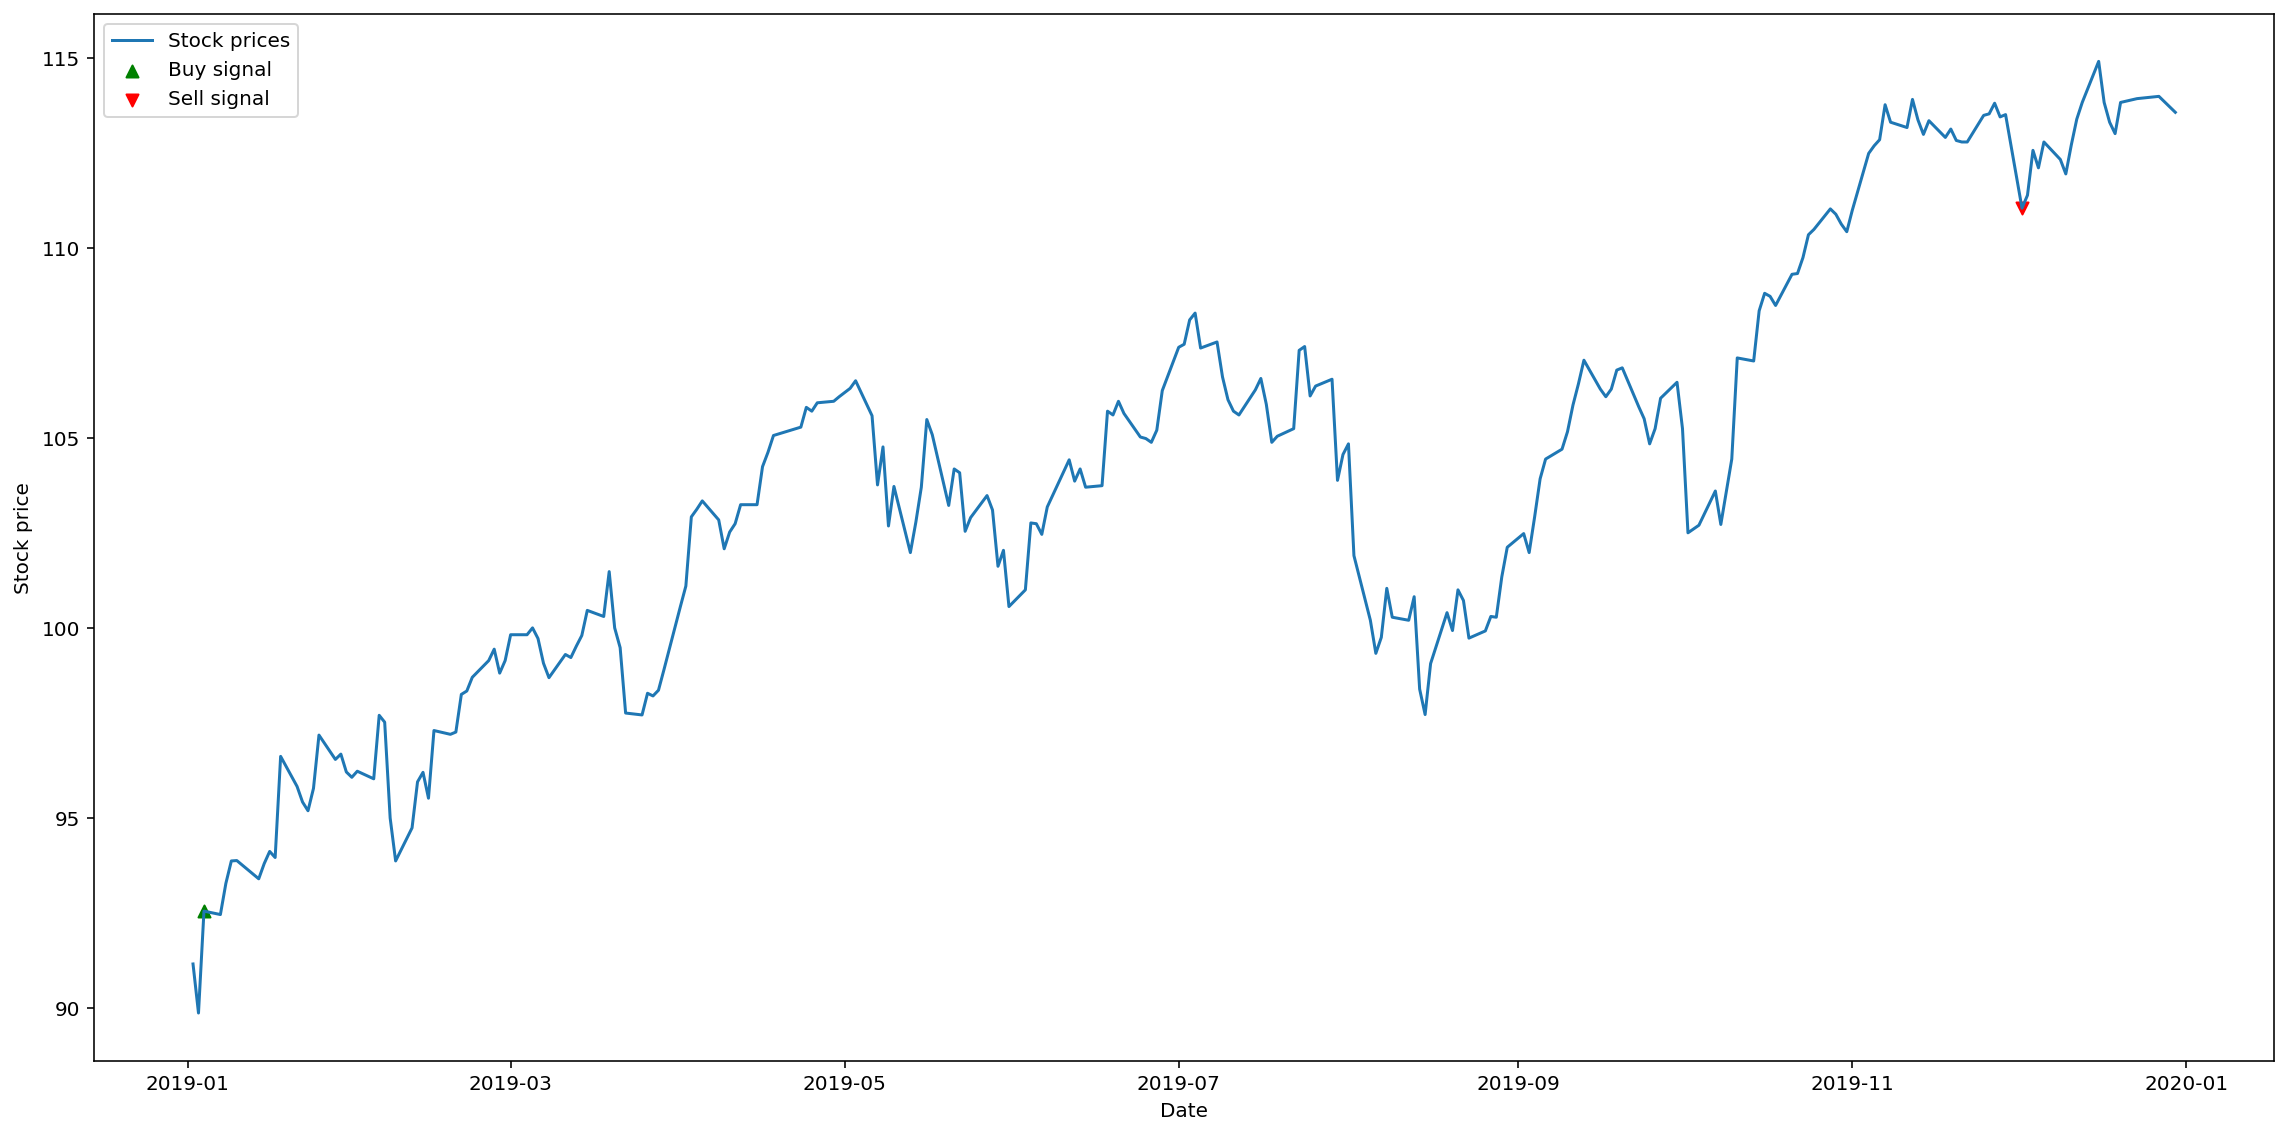

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=6)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-16.6473	112.49	4.01392	18.1962
1  	647   	-14.5276	110.049	9.18098	26.2391
2  	648   	-28.3222	114.648	17.9873	34.8506
3  	669   	-22.7403	124.826	37.3282	43.7073
4  	659   	-9.5214 	124.826	56.7862	44.5494
5  	645   	-53.4907	124.826	70.6453	43.1569
6  	642   	-18.1857	124.826	76.4277	43.4358
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Best average net profit: 28.388124519721327
CPU times: user 7min 21s, sys: 1 s, total: 7min 22s
Wall time: 7min 22s


In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[4, 1, 20], [14, 0]]
Net profit of strategy: 61.795275
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 34.650261%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 8
Number of sell signals: 8


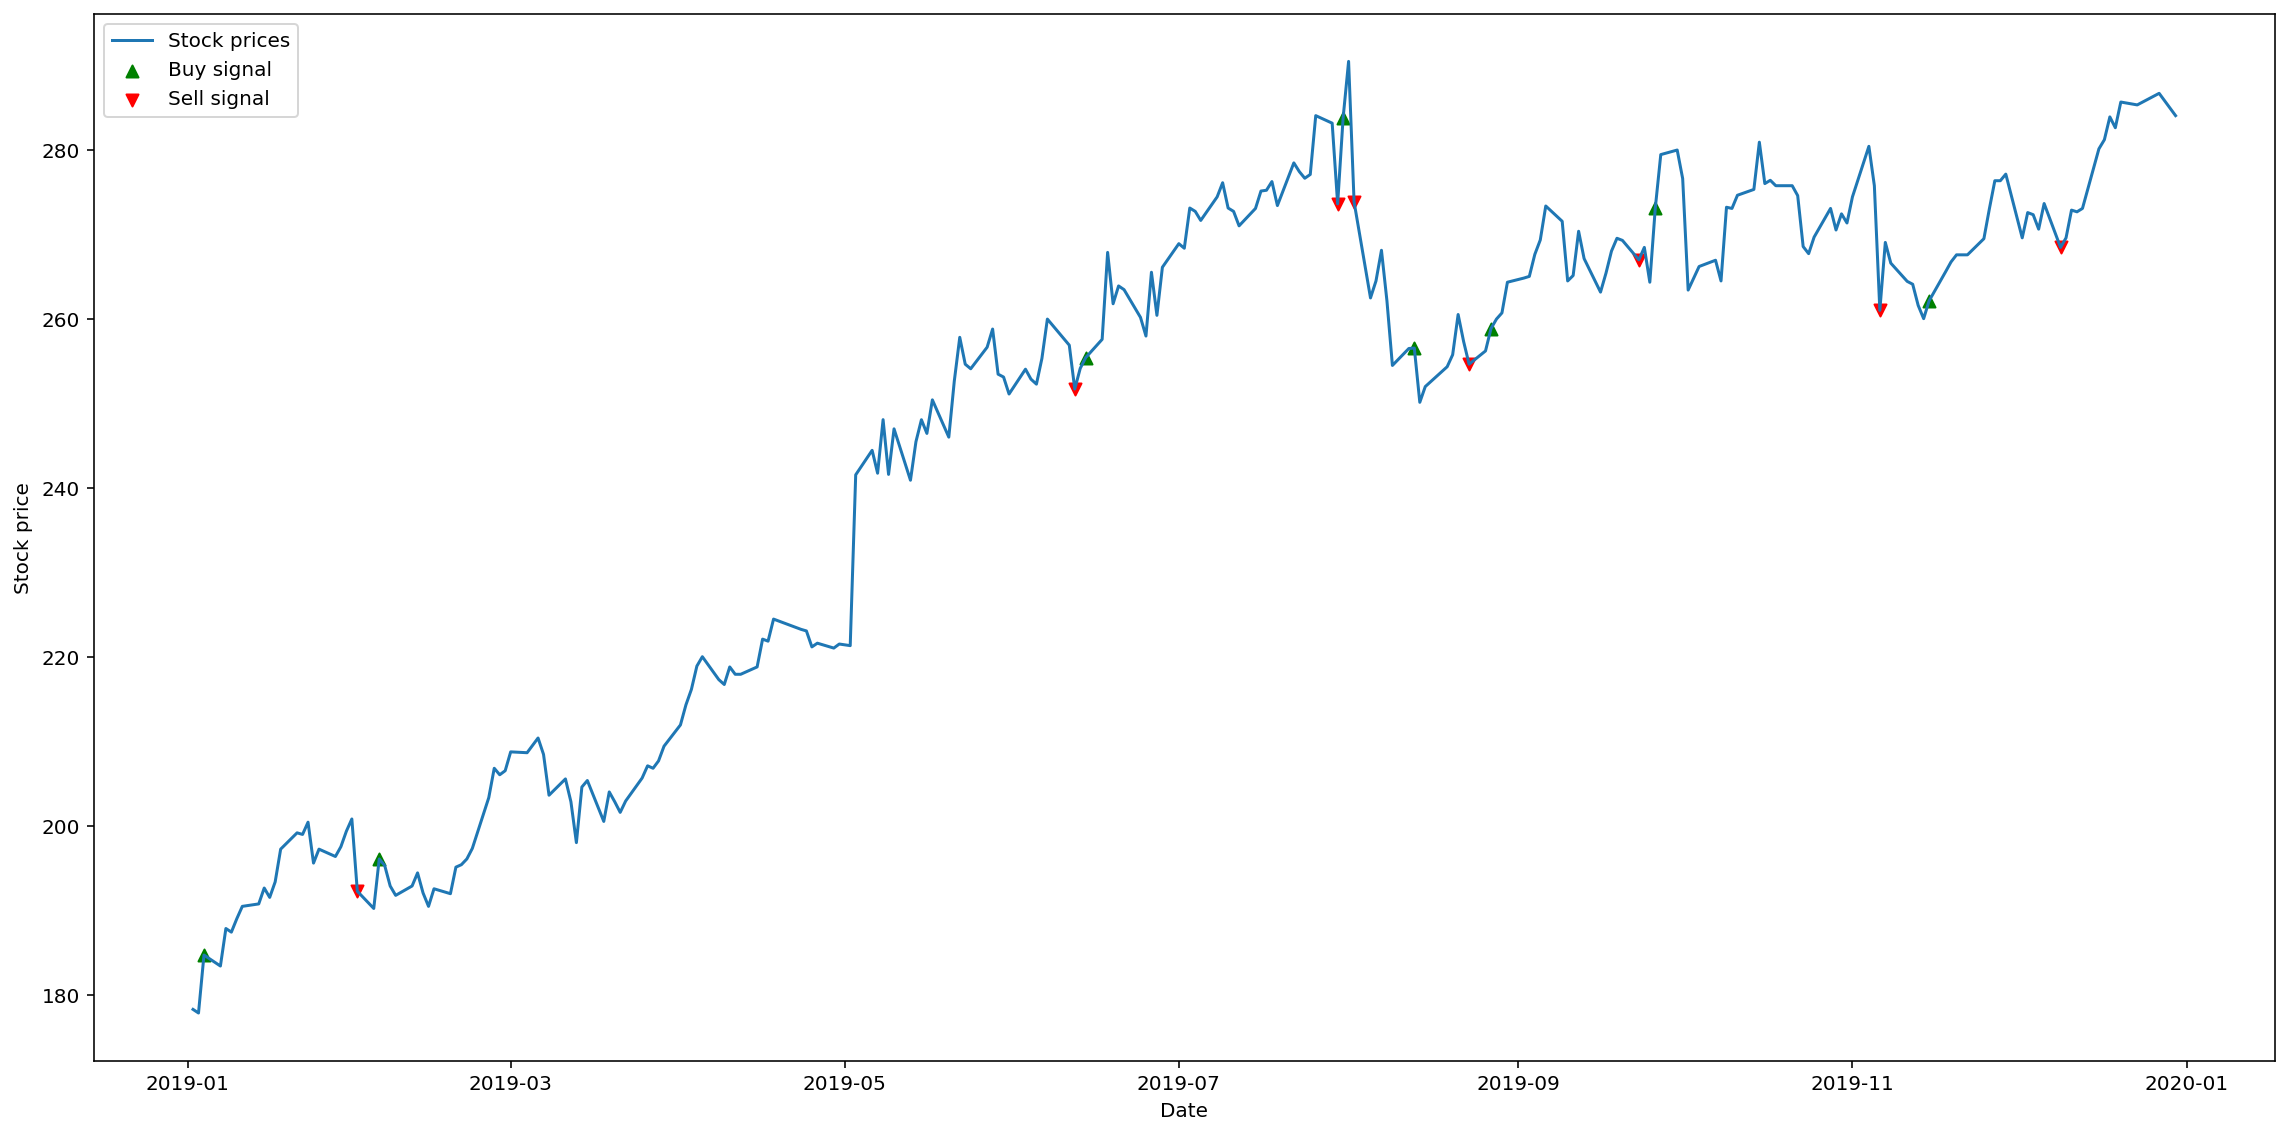

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-12.3836	61.1142	2.63173	11.3015
1  	647   	-12.3836	67.2504	6.93995	17.3808
2  	648   	-33.4117	73.4153	13.4925	22.5079
3  	669   	-12.3836	73.4153	25.4598	25.8418
4  	659   	-18.7887	79.3148	36.3655	25.3058
5  	645   	-29.4982	79.3148	42.7402	24.6053
6  	642   	-19.6686	79.3148	45.5064	25.218 
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Best average net profit: 7.264218792912216
CPU times: user 7min 46s, sys: 1.21 s, total: 7min 47s
Wall time: 7min 48s


In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[59, 74], [13, 63, 20], [4, 1]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 0
Number of sell signals: 0


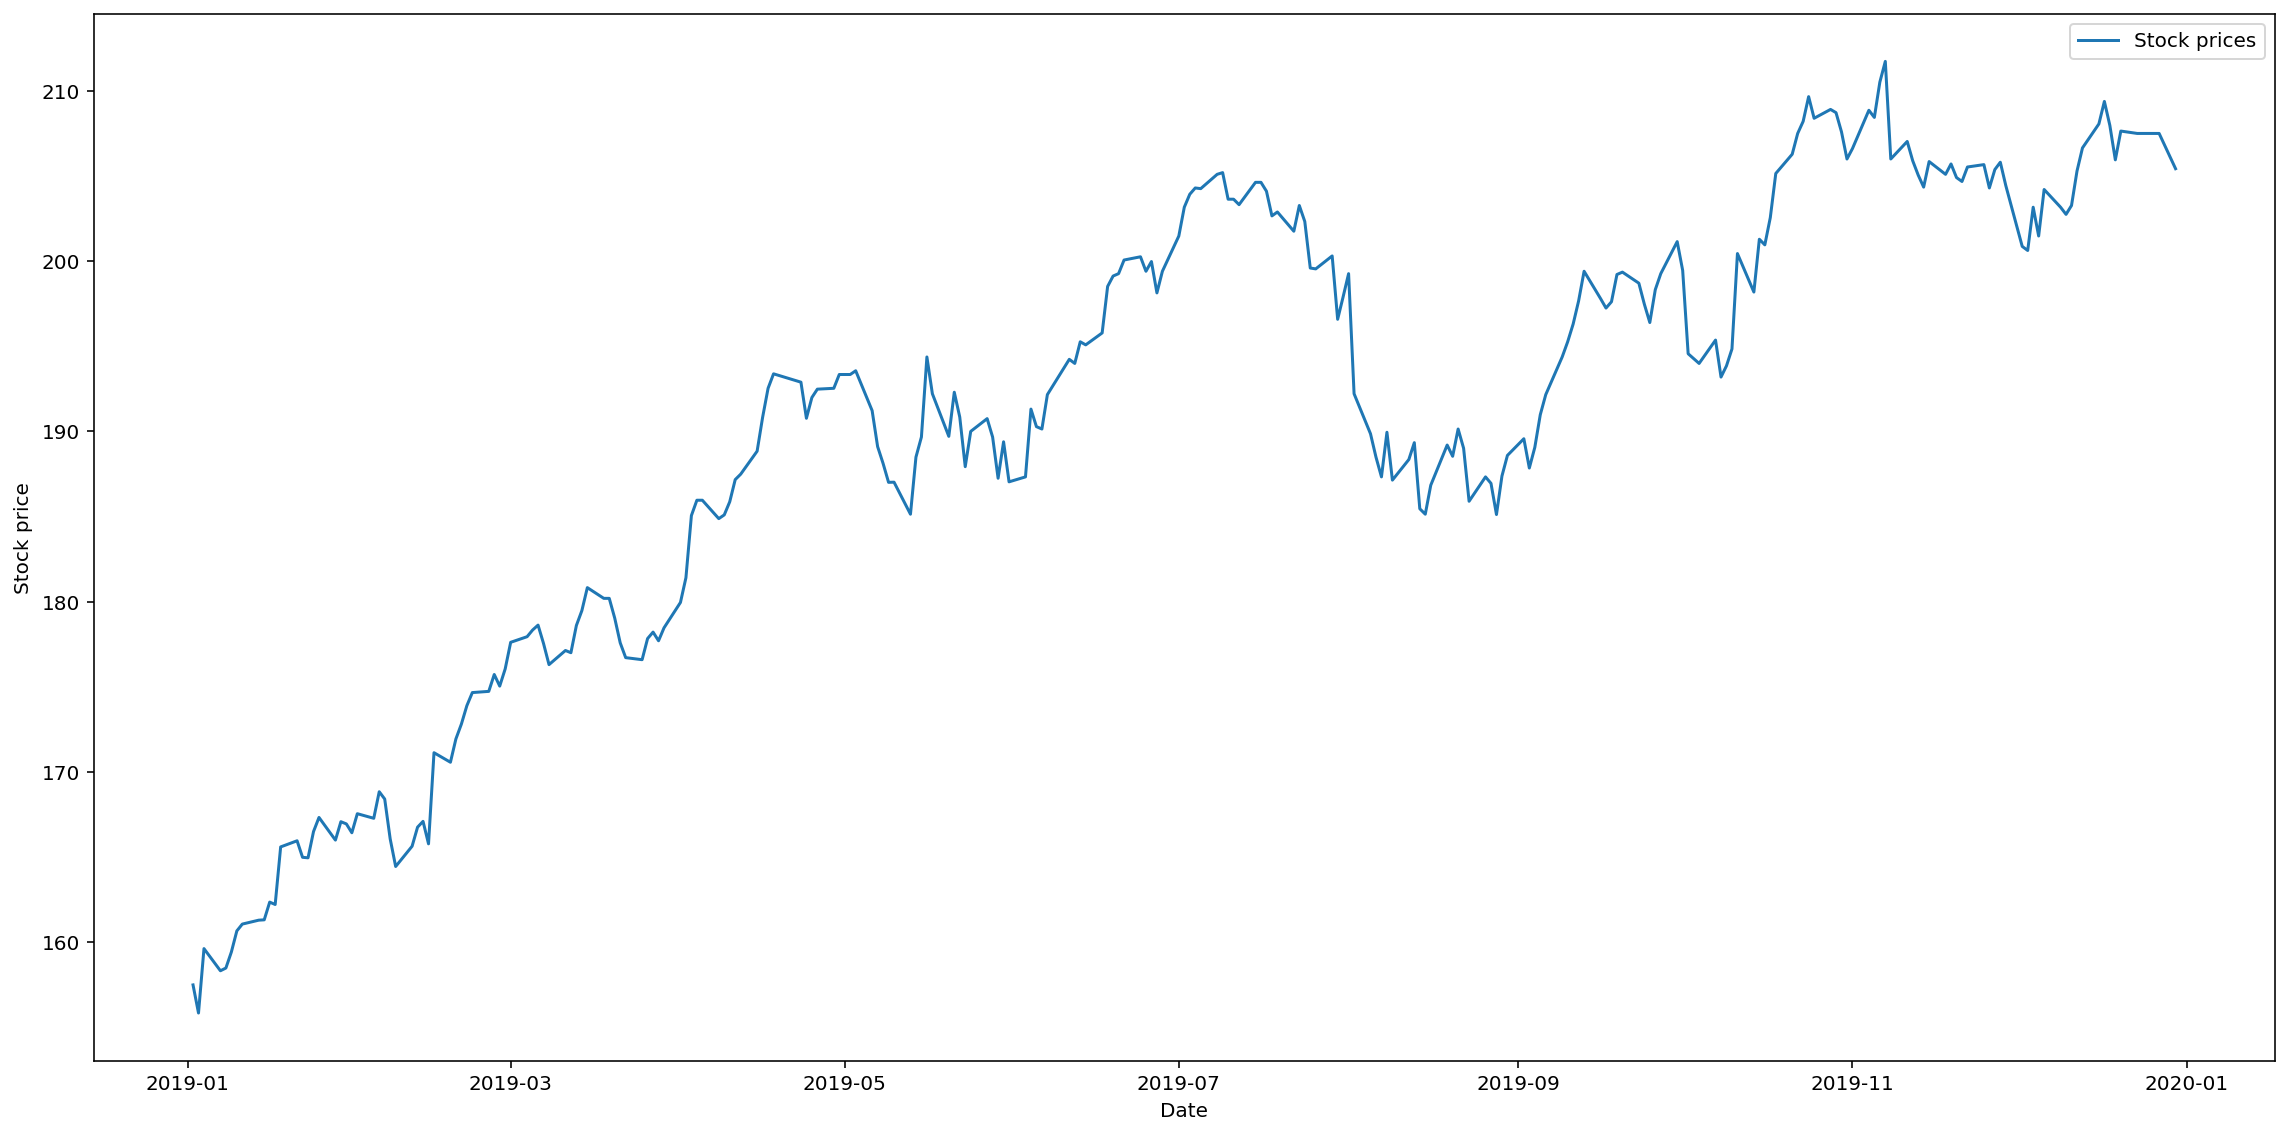

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-22.1554	31.5457	0.523182	3.67837
1  	647   	-17.9184	31.5457	1.23613 	5.01668
2  	648   	-13.2035	30.2901	2.52043 	6.91054
3  	669   	-14.9614	30.2901	4.794   	8.87301
4  	659   	-9.73662	30.2901	8.02337 	10.364 
5  	645   	-25.719 	30.2901	12.112  	11.2804
6  	642   	-28.2675	30.2901	14.7341 	11.3772
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
Best average net profit: 1.0820188555160453
CPU times: user 6min 51s, sys: 839 ms, total: 6min 52s
Wall time: 6min 53s


In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[60, 58], [9, 40, 13], [14, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 0
Number of sell signals: 0


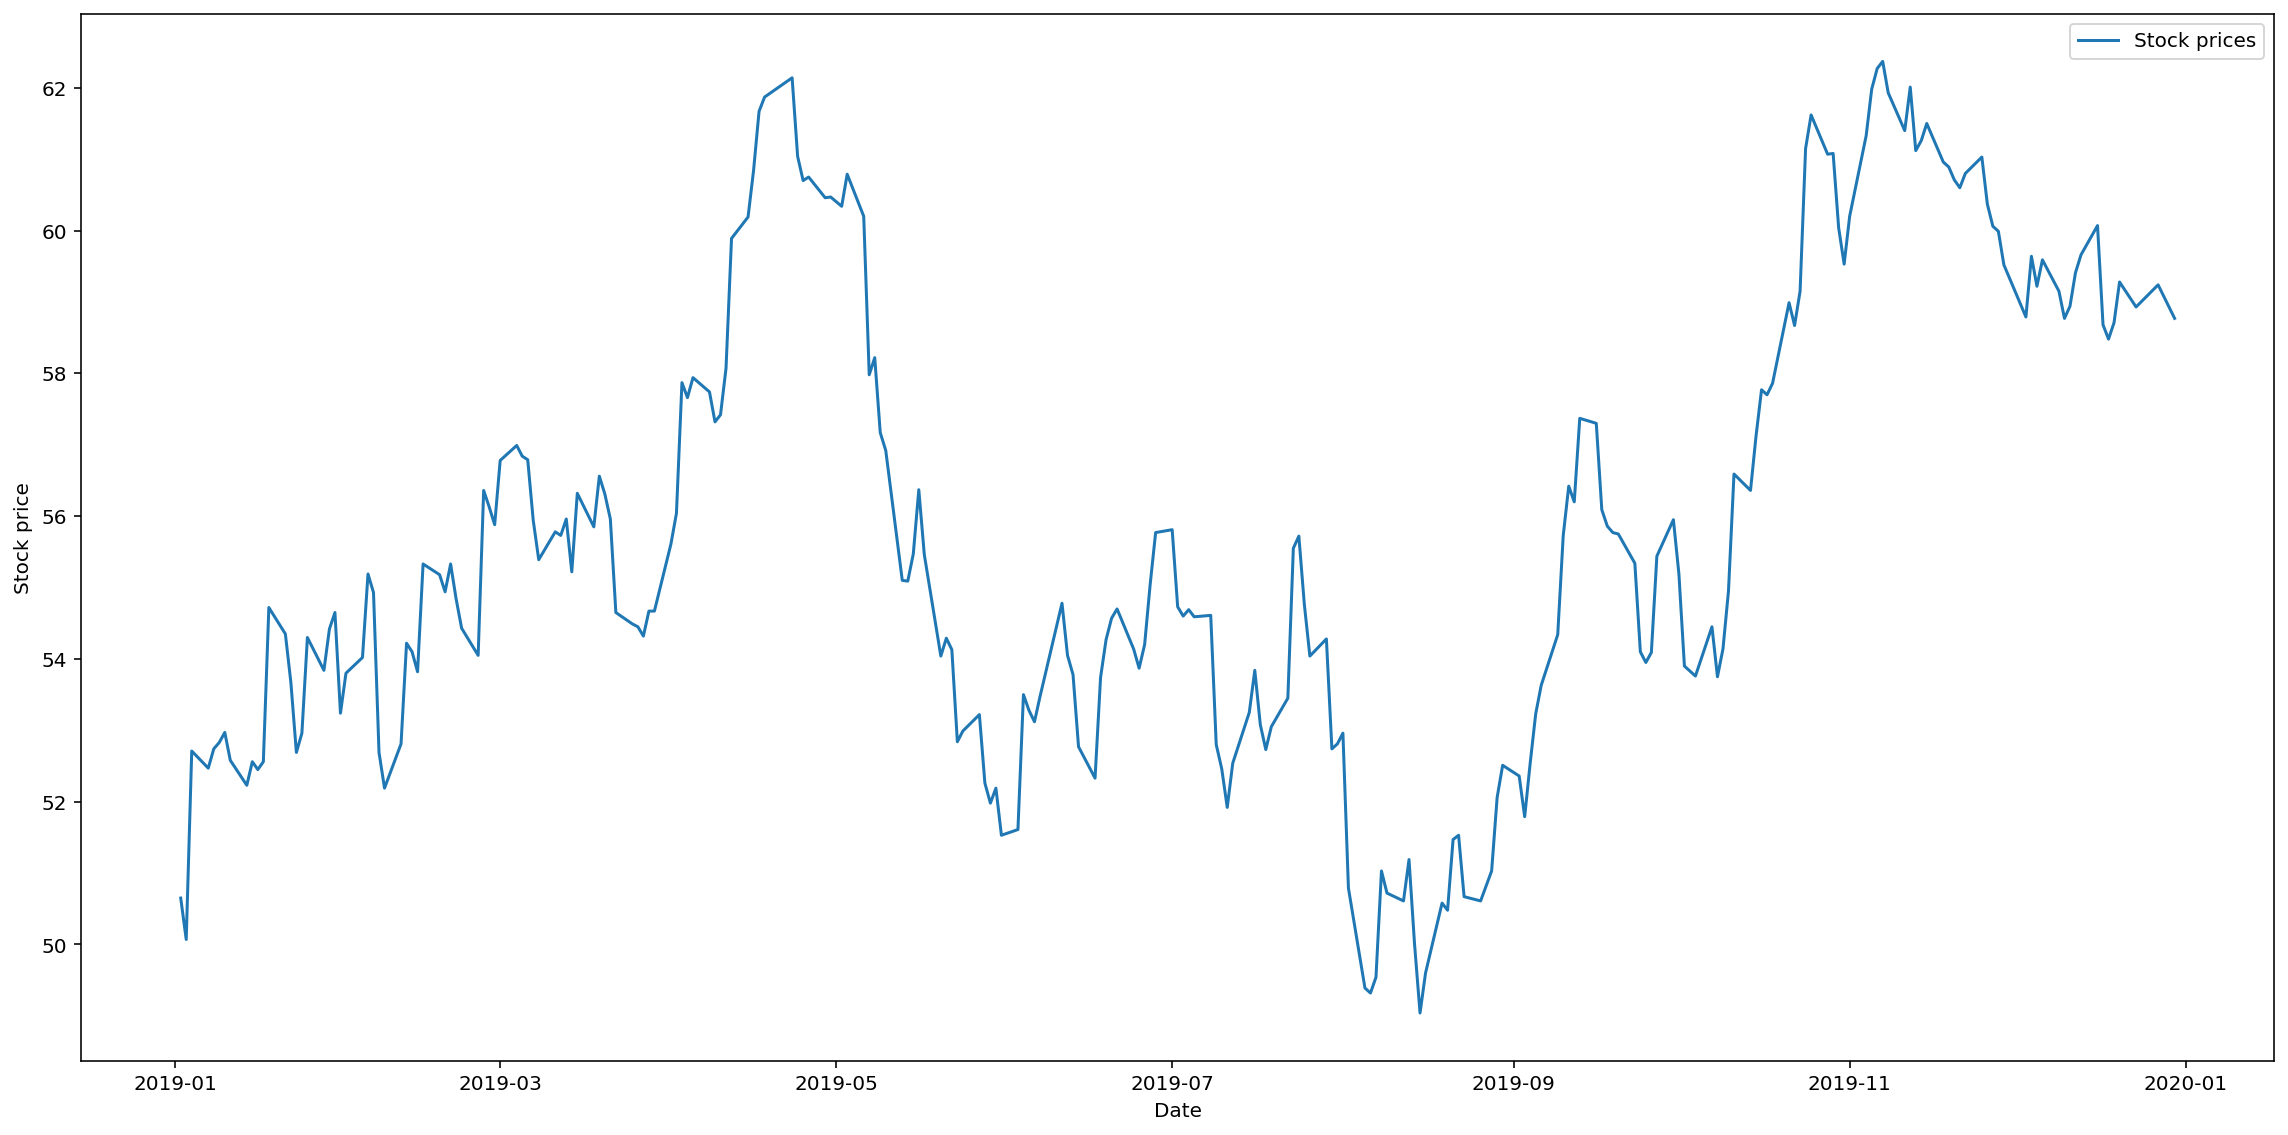

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std     
0  	1000  	-10.0074	2.89545	-0.103902	0.913656
1  	647   	-8.57353	3.63375	0.0129038	0.662792
2  	648   	-8.48248	3.63375	0.0350563	0.814574
3  	669   	-9.3567 	3.63375	0.145087 	0.973187
4  	659   	-10.9453	4.41438	0.30614  	1.36582 
5  	645   	-10.6786	4.41438	0.585569 	1.58116 
6  	642   	-10.475 	4.41438	1.00653  	1.82307 
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Best average net profit: 0.0
CPU times: user 6min 27s, sys: 869 ms, total: 6min 27s
Wall time: 6min 28s


In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'ROC', 'BollingerBaender']
Active rules' parameters: [[126, 234], [88], [57, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: -0.144875
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 0
Number of sell signals: 0


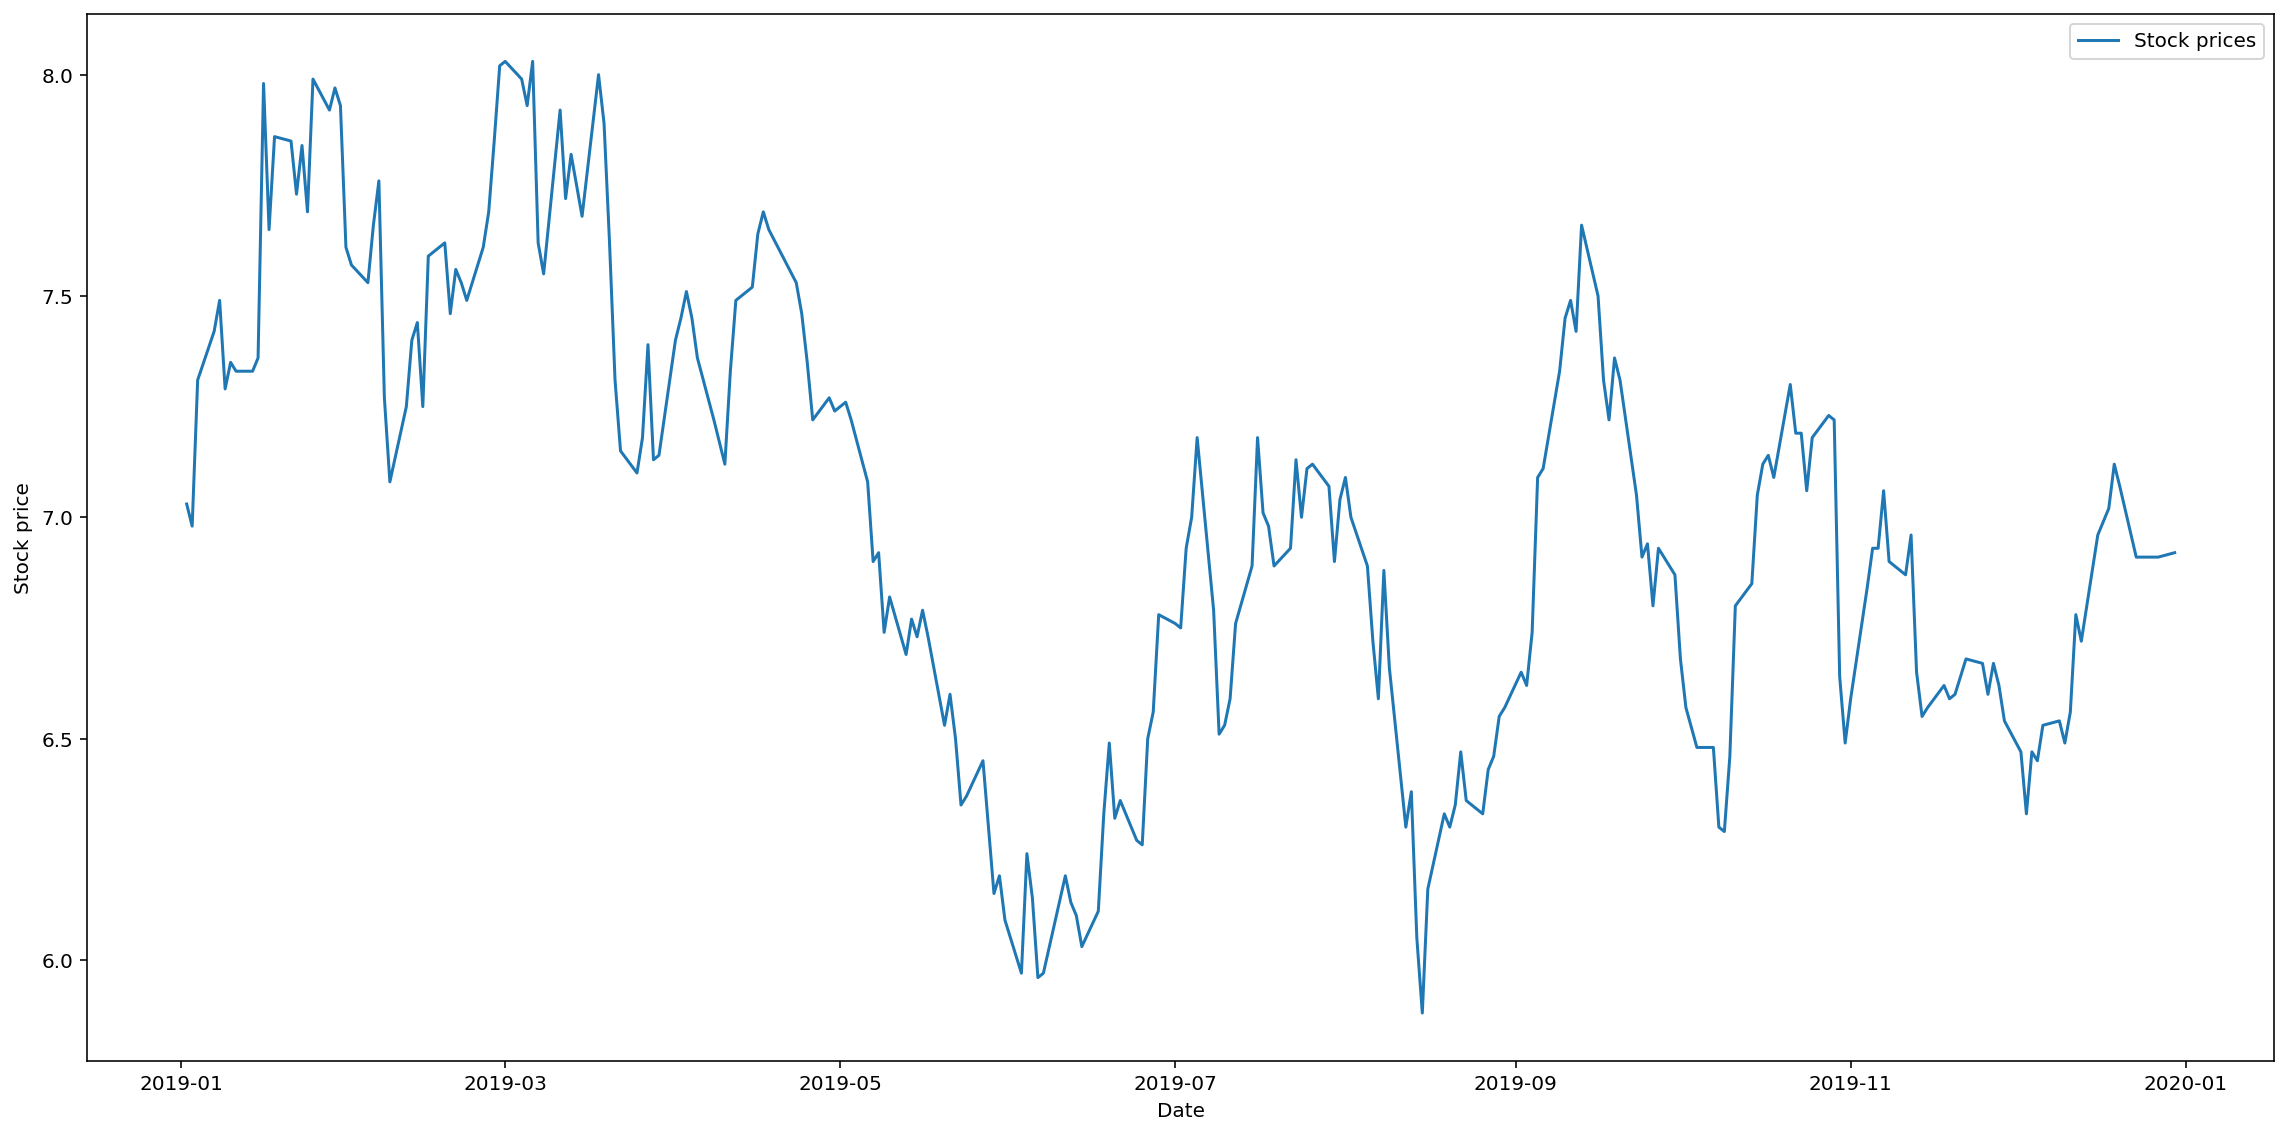

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max   	mean     	std     
0  	1000  	-6.06657	2.6994	0.0170773	0.315672
1  	647   	-1.9338 	2.36403	0.0750765	0.328661
2  	648   	-1.27253	2.63305	0.143131 	0.429093
3  	669   	-1.9729 	2.82207	0.291216 	0.596098
4  	659   	-2.31622	2.82207	0.533908 	0.714862
5  	645   	-3.79958	3.29618	0.819364 	0.784834
6  	642   	-4.7582 	3.29618	0.96412  	0.828169
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Best average net profit: 0.915557548325812
CPU times: user 6min 32s, sys: 789 ms, total: 6min 33s
Wall time: 6min 34s


In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[37, 55, 59], [4, 0]]
Net profit of strategy: 0.503875
Net profit of buy and hold: 0.314450
Percentage profit of strategy: 3.899961%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 3
Number of sell signals: 3


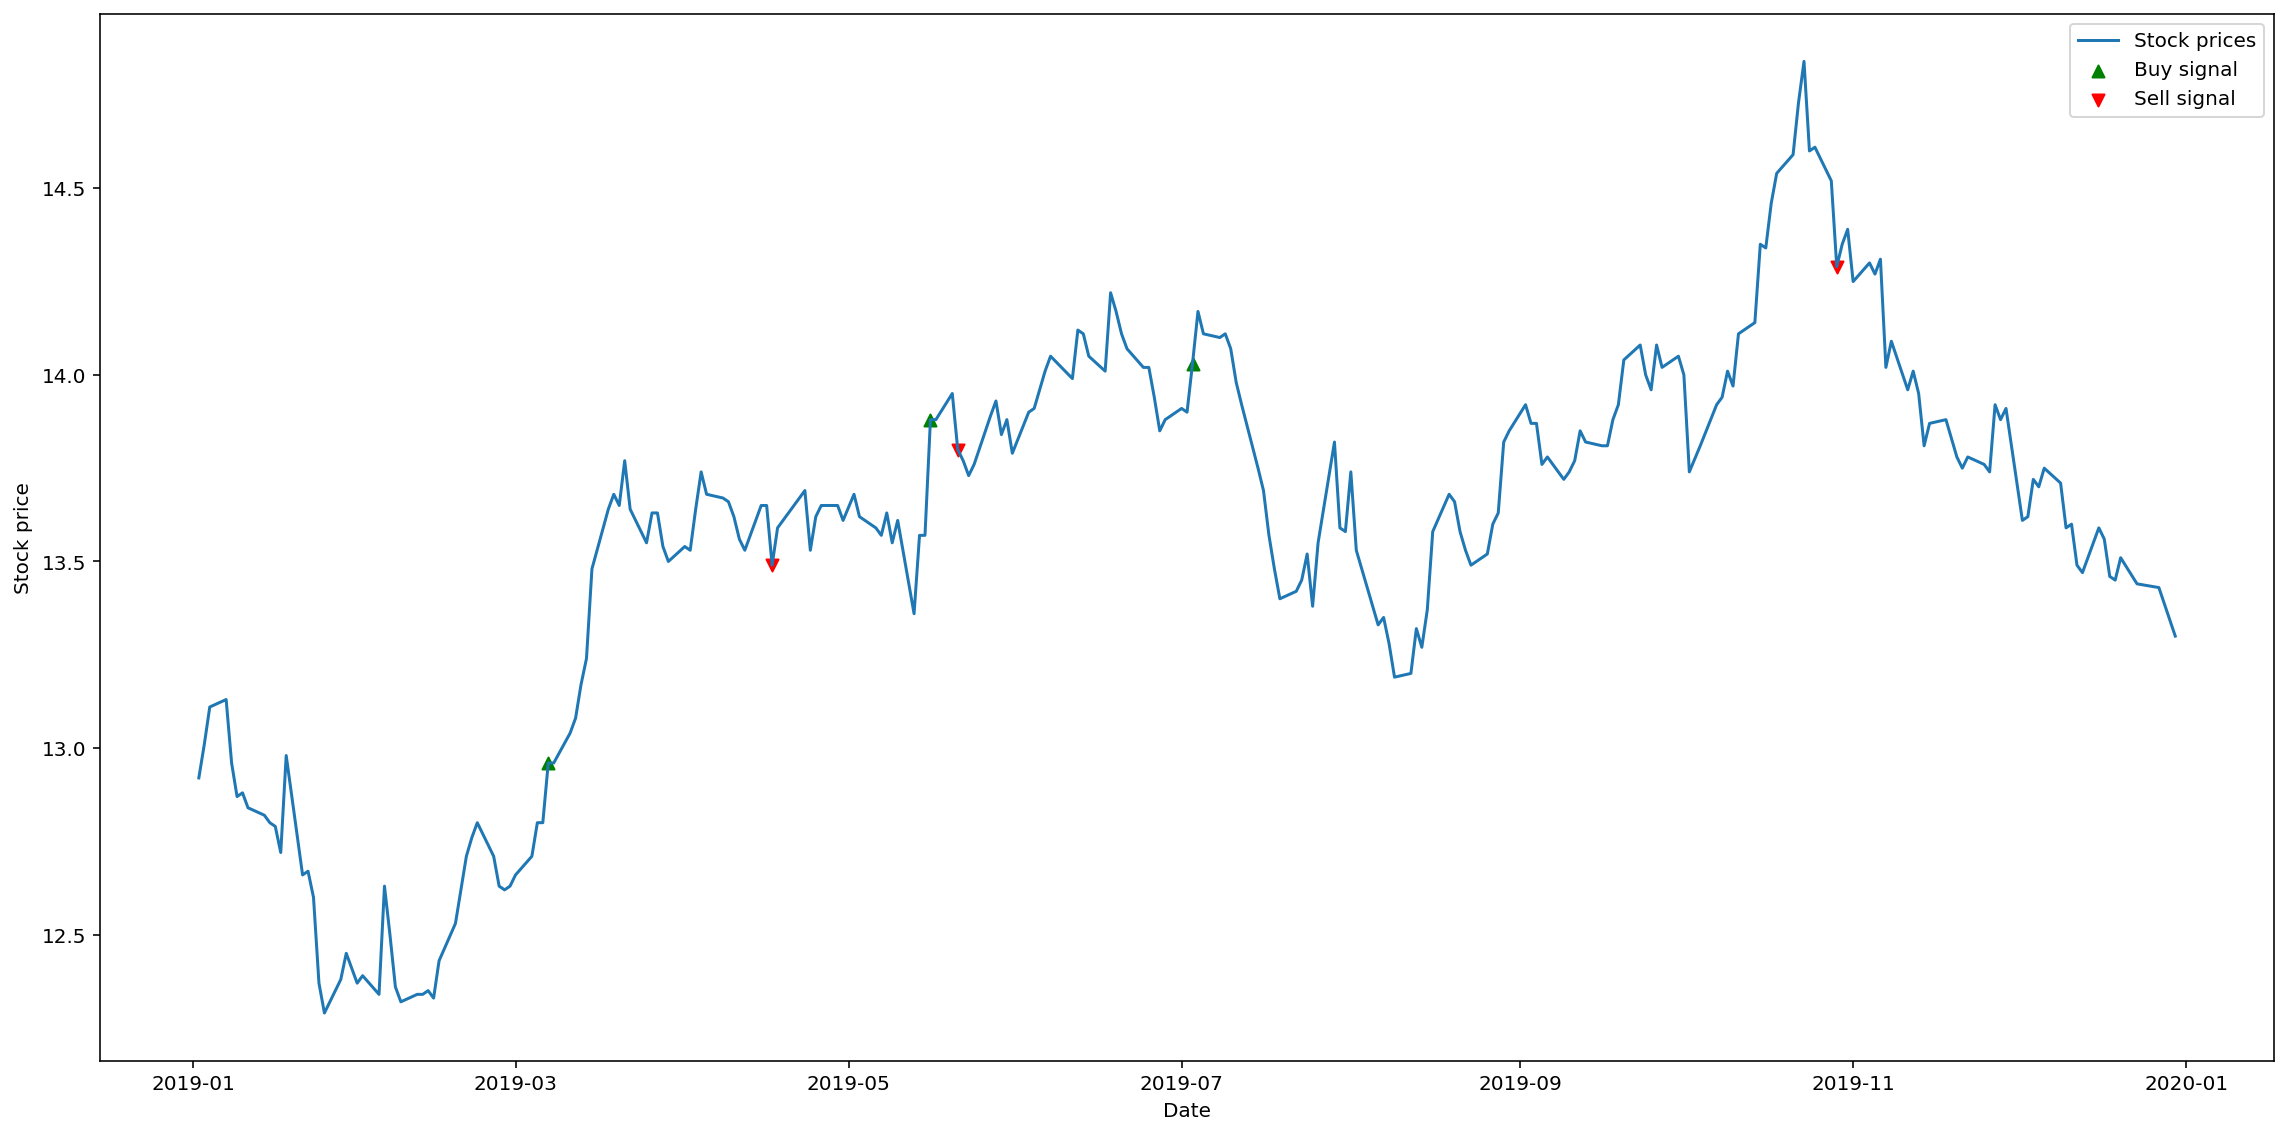

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min    	max   	mean    	std   
0  	1000  	-8.2308	31.211	0.699579	4.2397
1  	647   	-10.7281	35.2162	1.91785 	6.65646
2  	648   	-14.1609	36.1754	3.63431 	8.90684
3  	669   	-14.1609	39.2062	7.03925 	11.3613
4  	659   	-10.7281	39.2062	11.8951 	12.8697
5  	645   	-14.1609	40.2322	16.3407 	13.1642
6  	642   	-14.1609	41.3596	20.5537 	12.6912
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Best average net profit: 4.161453391074144
CPU times: user 6min 44s, sys: 957 ms, total: 6min 45s
Wall time: 6min 46s


In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[19, 31, 31], [14, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 32.969475
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 0
Number of sell signals: 0


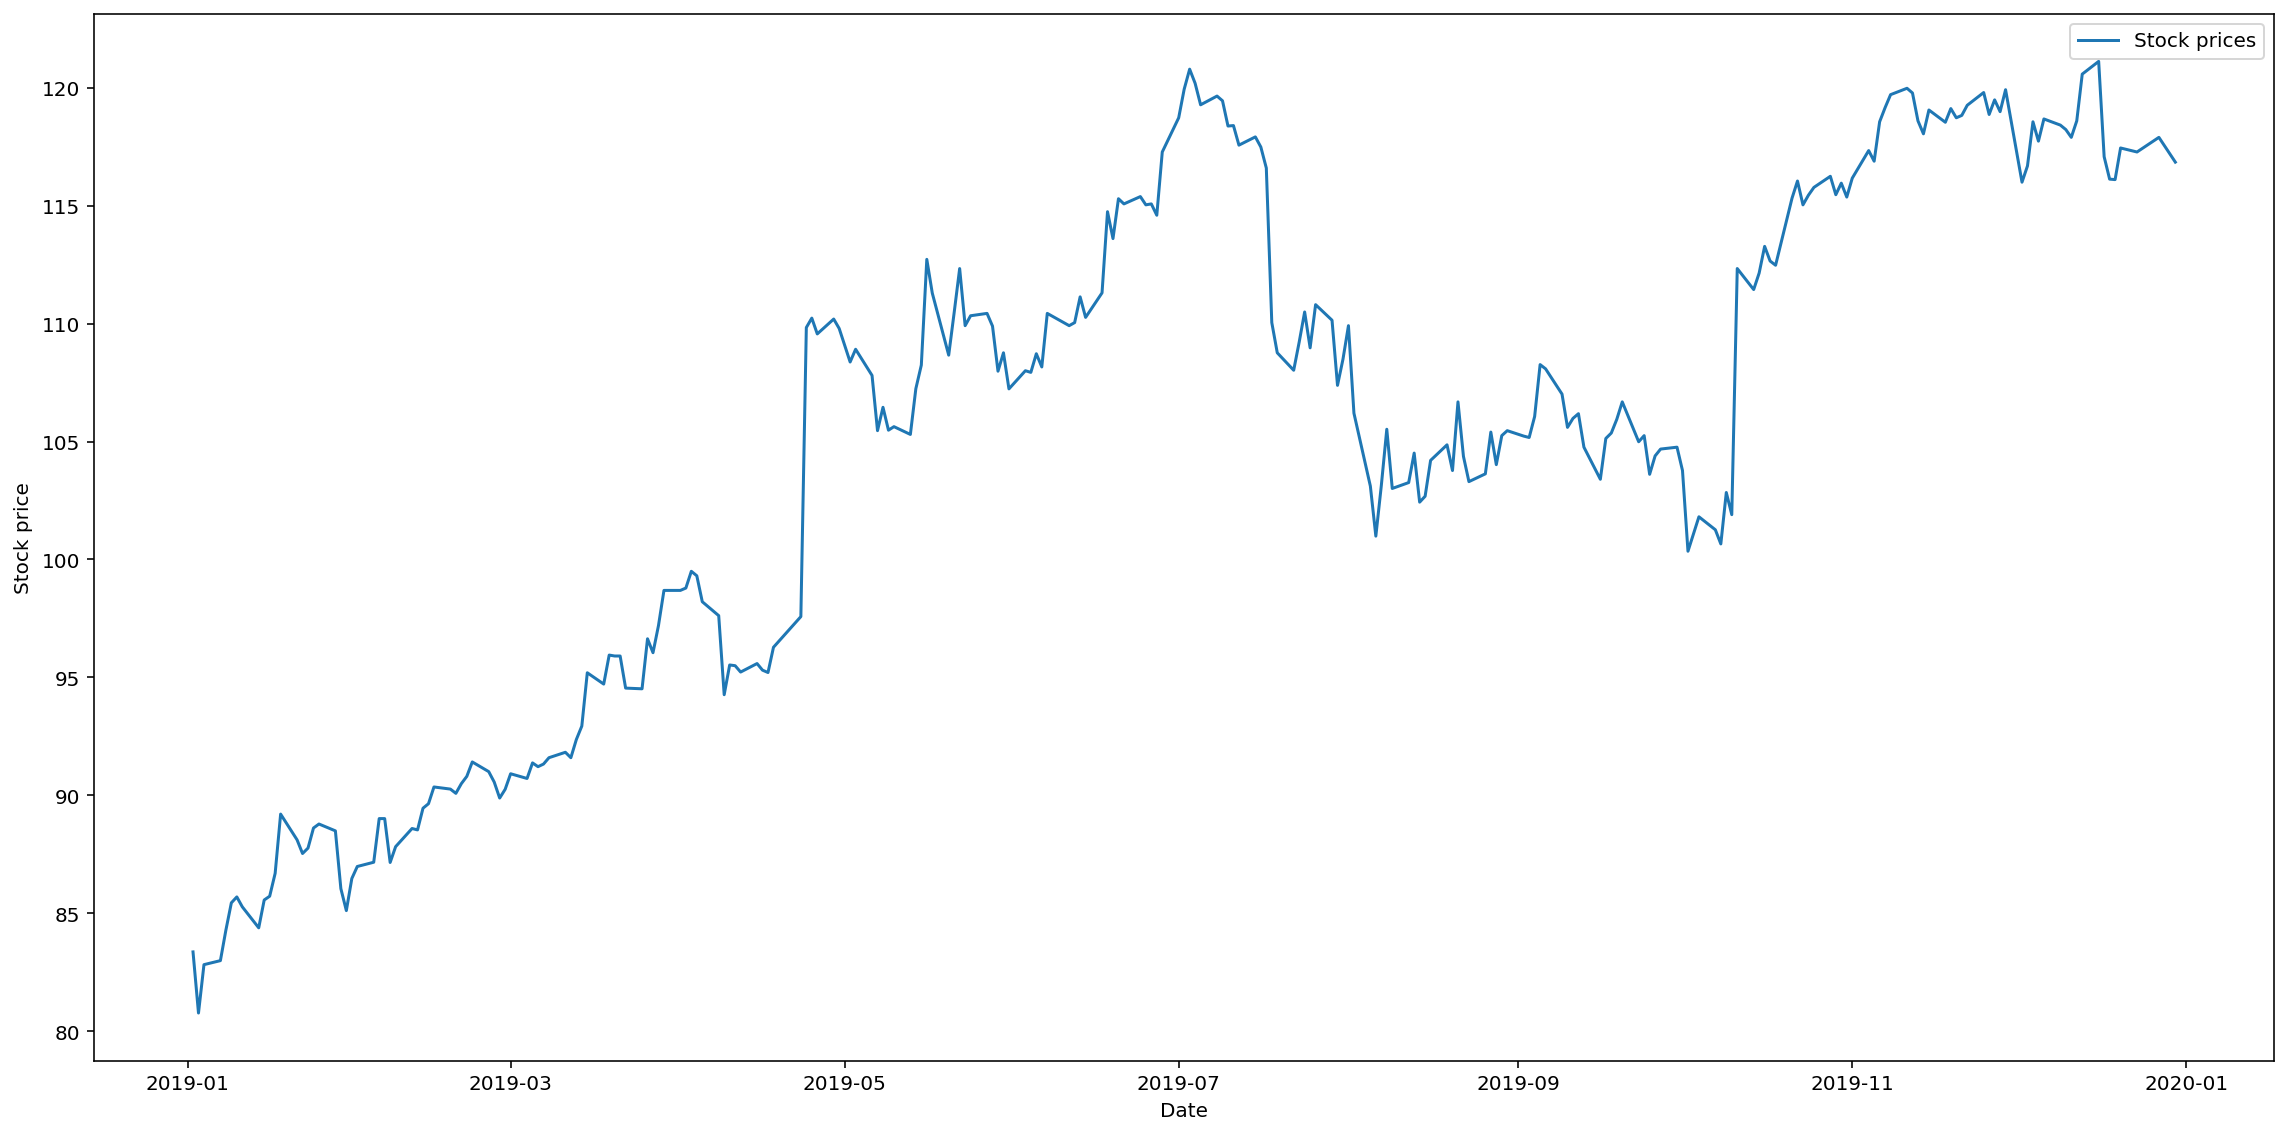

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean  	std    
0  	1000  	-3202.47	8643.15	235.08	1246.19
1  	647   	-420.482	9080.27	513.295	1820.93
2  	648   	-407.503	9080.27	927.084	2316.87
3  	669   	-2290.61	9086.84	1734.23	2891.62
4  	659   	-492.114	9101.72	3302.99	3364.77
5  	645   	-2384.06	9190   	4858.23	3355.97
6  	642   	-558.457	9289.19	5454.02	3372.78
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
Best average net profit: 1002.2987047864815
CPU times: user 6min 55s, sys: 472 ms, total: 6min 55s
Wall time: 6min 56s


In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[27, 59, 20], [29, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 0
Number of sell signals: 0


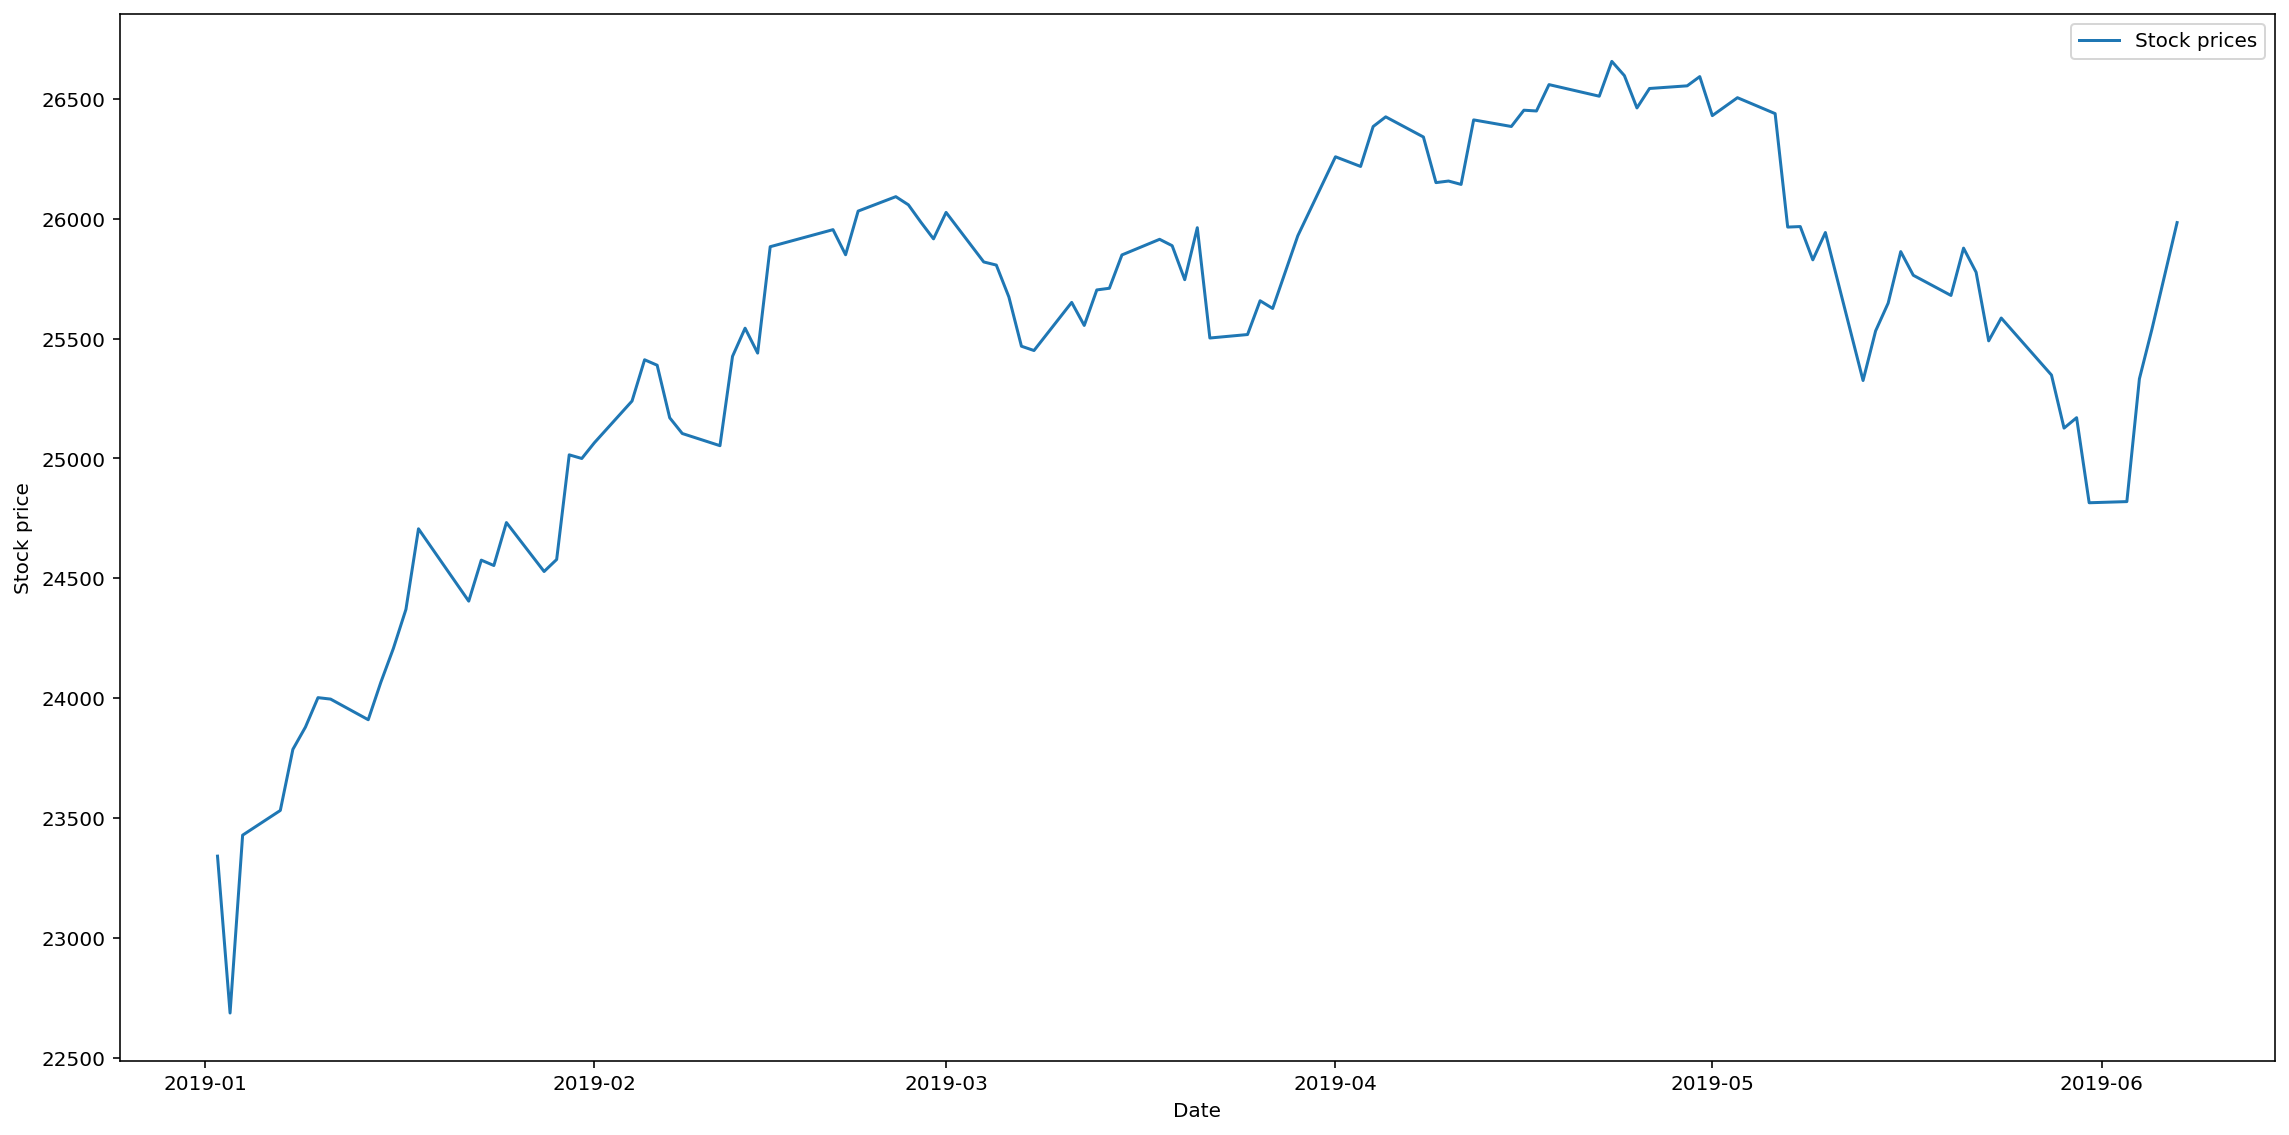

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min	max    	mean    	std    
0  	1000  	0  	22.9403	0.818935	3.27615
1  	647   	-0.472525	22.9905	1.84847 	4.6211 
2  	648   	-0.23705 	23.2476	3.72027 	6.06557
3  	669   	-2.91003 	24.3672	7.2376  	7.34777
4  	659   	-1.0451  	23.5796	10.9627 	7.7493 
5  	645   	-4.64185 	23.7555	13.8343 	7.63243
6  	642   	-11.562  	24.7099	15.5196 	7.7489 
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Best average net profit: 6.690243135277357
CPU times: user 6min 45s, sys: 230 ms, total: 6min 46s
Wall time: 6min 46s


In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'MACD', 'BollingerBaender']
Active rules' parameters: [[7], [51, 37, 4], [14, 0]]
Net profit of strategy: 2.219500
Net profit of buy and hold: 5.462050
Percentage profit of strategy: 5.446626%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 2
Number of sell signals: 2


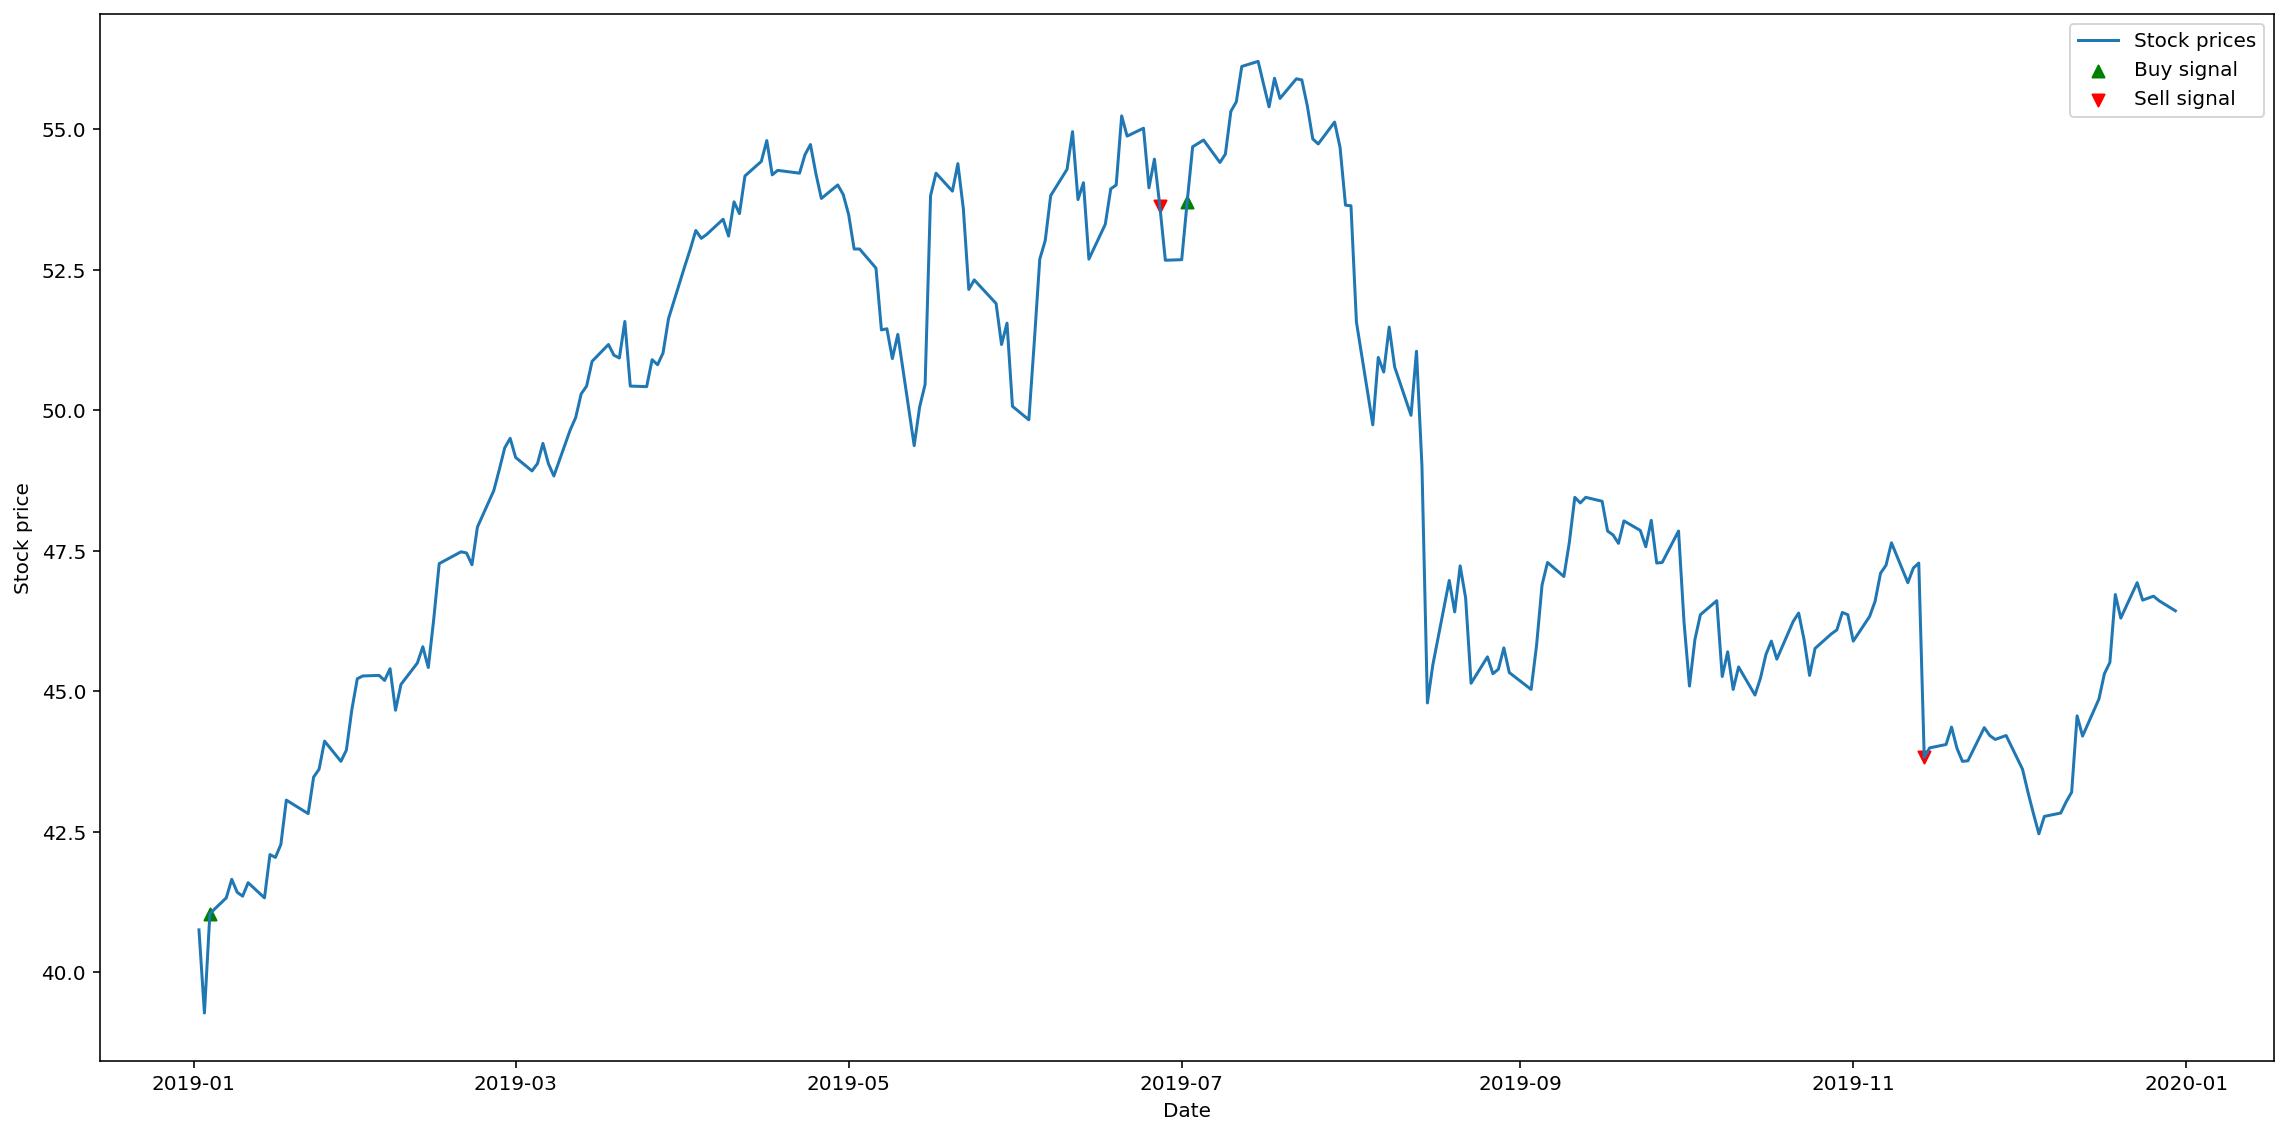

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17.1555	42.1277	0.781402	4.94722
1  	647   	-6.17242	42.1277	1.69481 	7.11299
2  	648   	-17.1754	42.1277	3.27474 	9.52295
3  	669   	-12.6441	42.1277	6.41696 	12.4376
4  	659   	-17.7019	43.1712	10.6325 	14.787 
5  	645   	-6.17318	46.2787	16.5101 	16.018 
6  	642   	-15.9955	42.9025	22.0557 	15.6641
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Best average net profit: 1.6484387833671645
CPU times: user 5min 52s, sys: 203 ms, total: 5min 52s
Wall time: 5min 53s


In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'STO', 'BollingerBaender']
Active rules' parameters: [[74], [47, 3], [18, 1]]
Net profit of strategy: -9.063975
Net profit of buy and hold: -13.107875
Percentage profit of strategy: -12.255239%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 1
Number of sell signals: 1


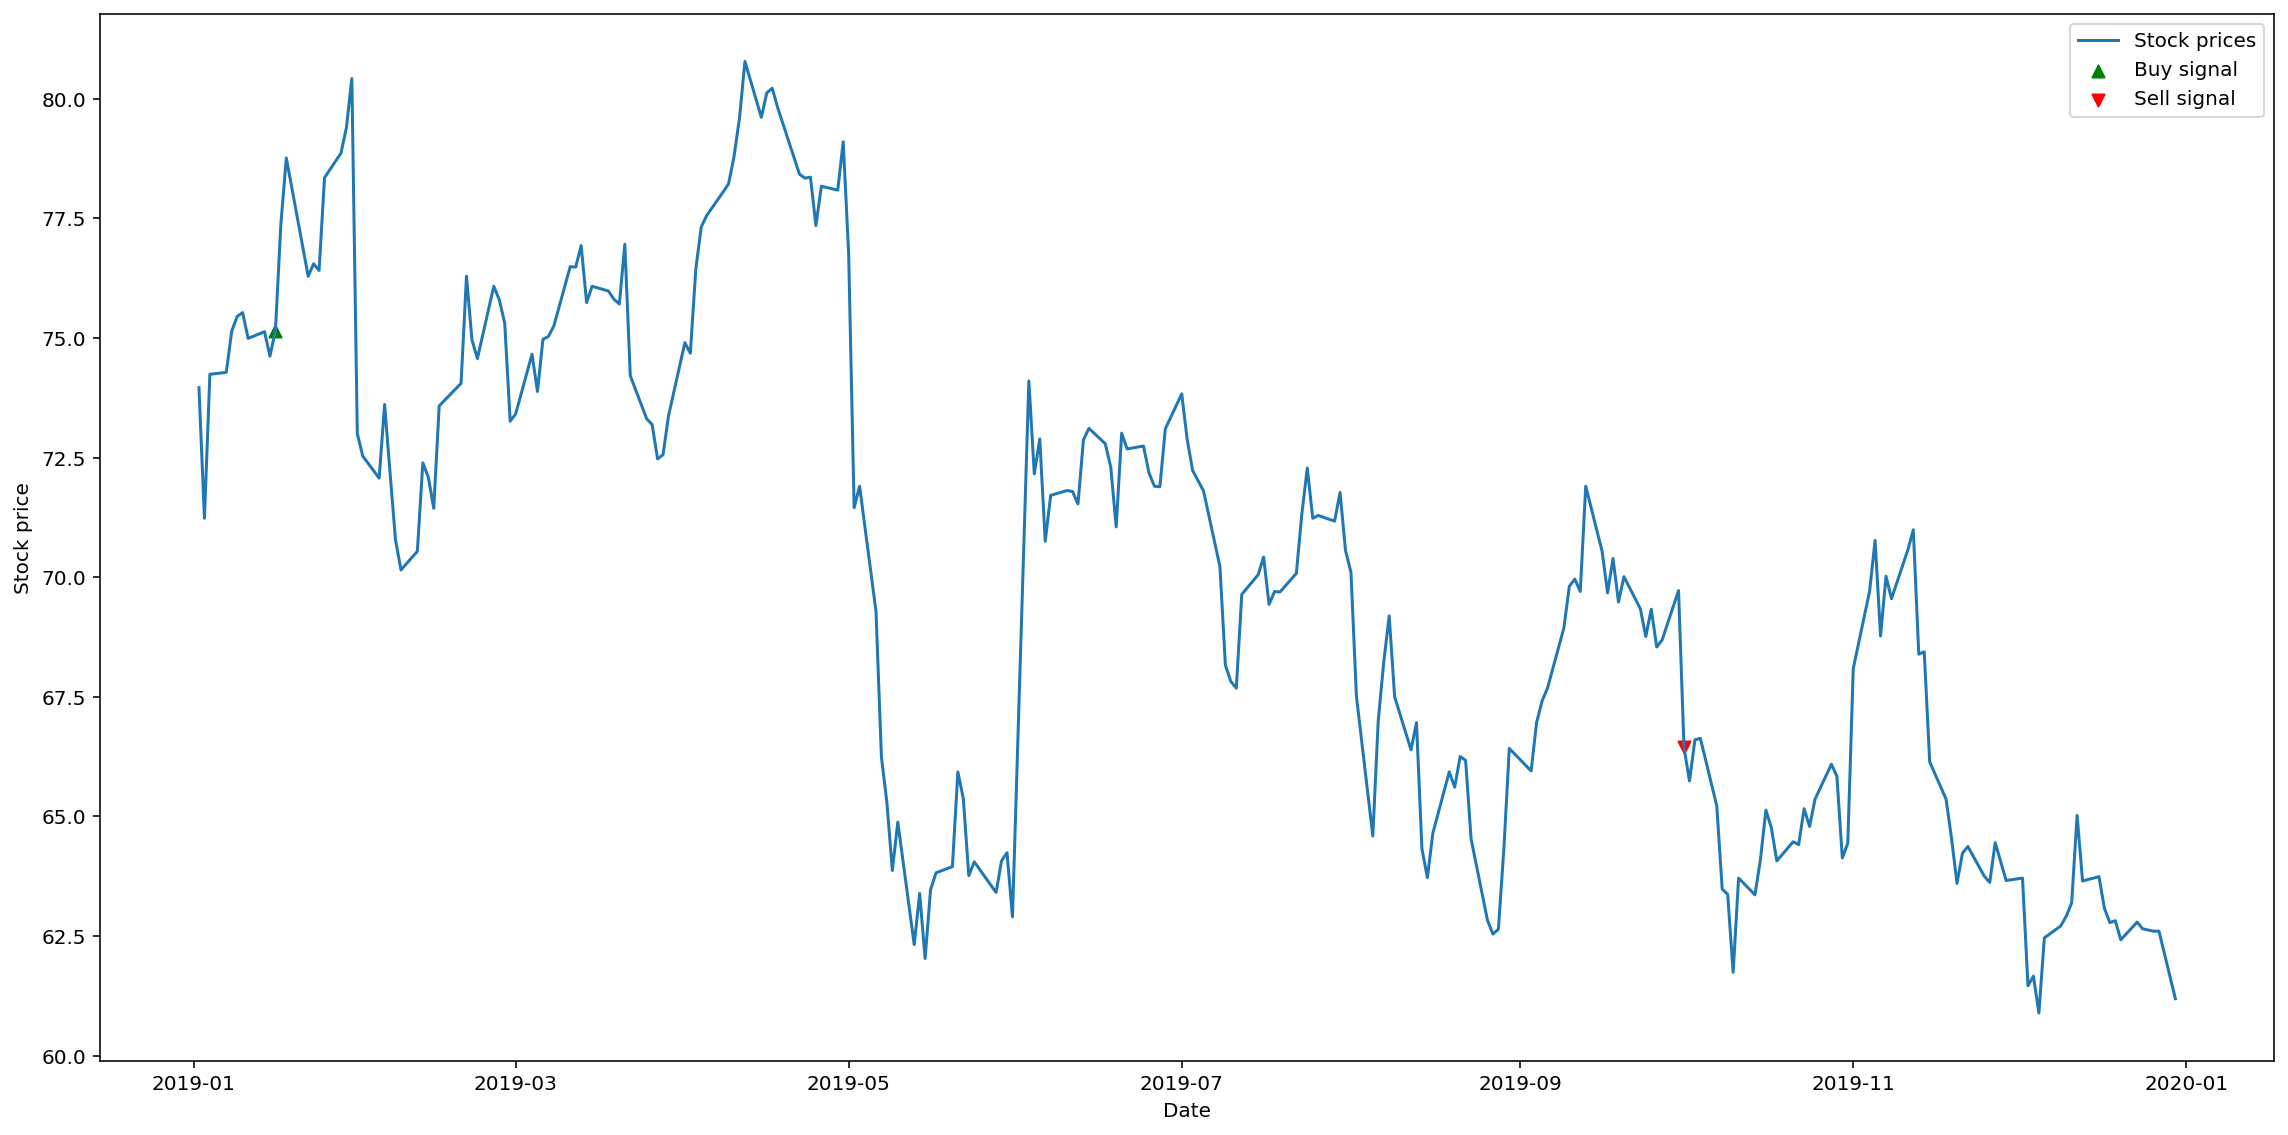

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min    	max    	mean   	std    
0  	1000  	-7.9801	52.7565	1.86022	8.60059
1  	647   	-3.50157	53.8181	4.39047	12.6044
2  	648   	-8.32092	53.8181	9.34923	17.5338
3  	669   	-3.50157	54.9119	17.6237	21.4279
4  	659   	-5.17345	56.6611	26.4945	21.9177
5  	645   	-9.36283	56.7335	34.5419	20.4109
6  	642   	-11.2841	56.7335	38.4601	19.963 
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Best average net profit: 4.404978848338251
CPU times: user 6min 40s, sys: 258 ms, total: 6min 40s
Wall time: 6min 40s


In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[59, 41, 14], [38, 0]]
Net profit of strategy: 2.416425
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 2.576421%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 3
Number of sell signals: 3


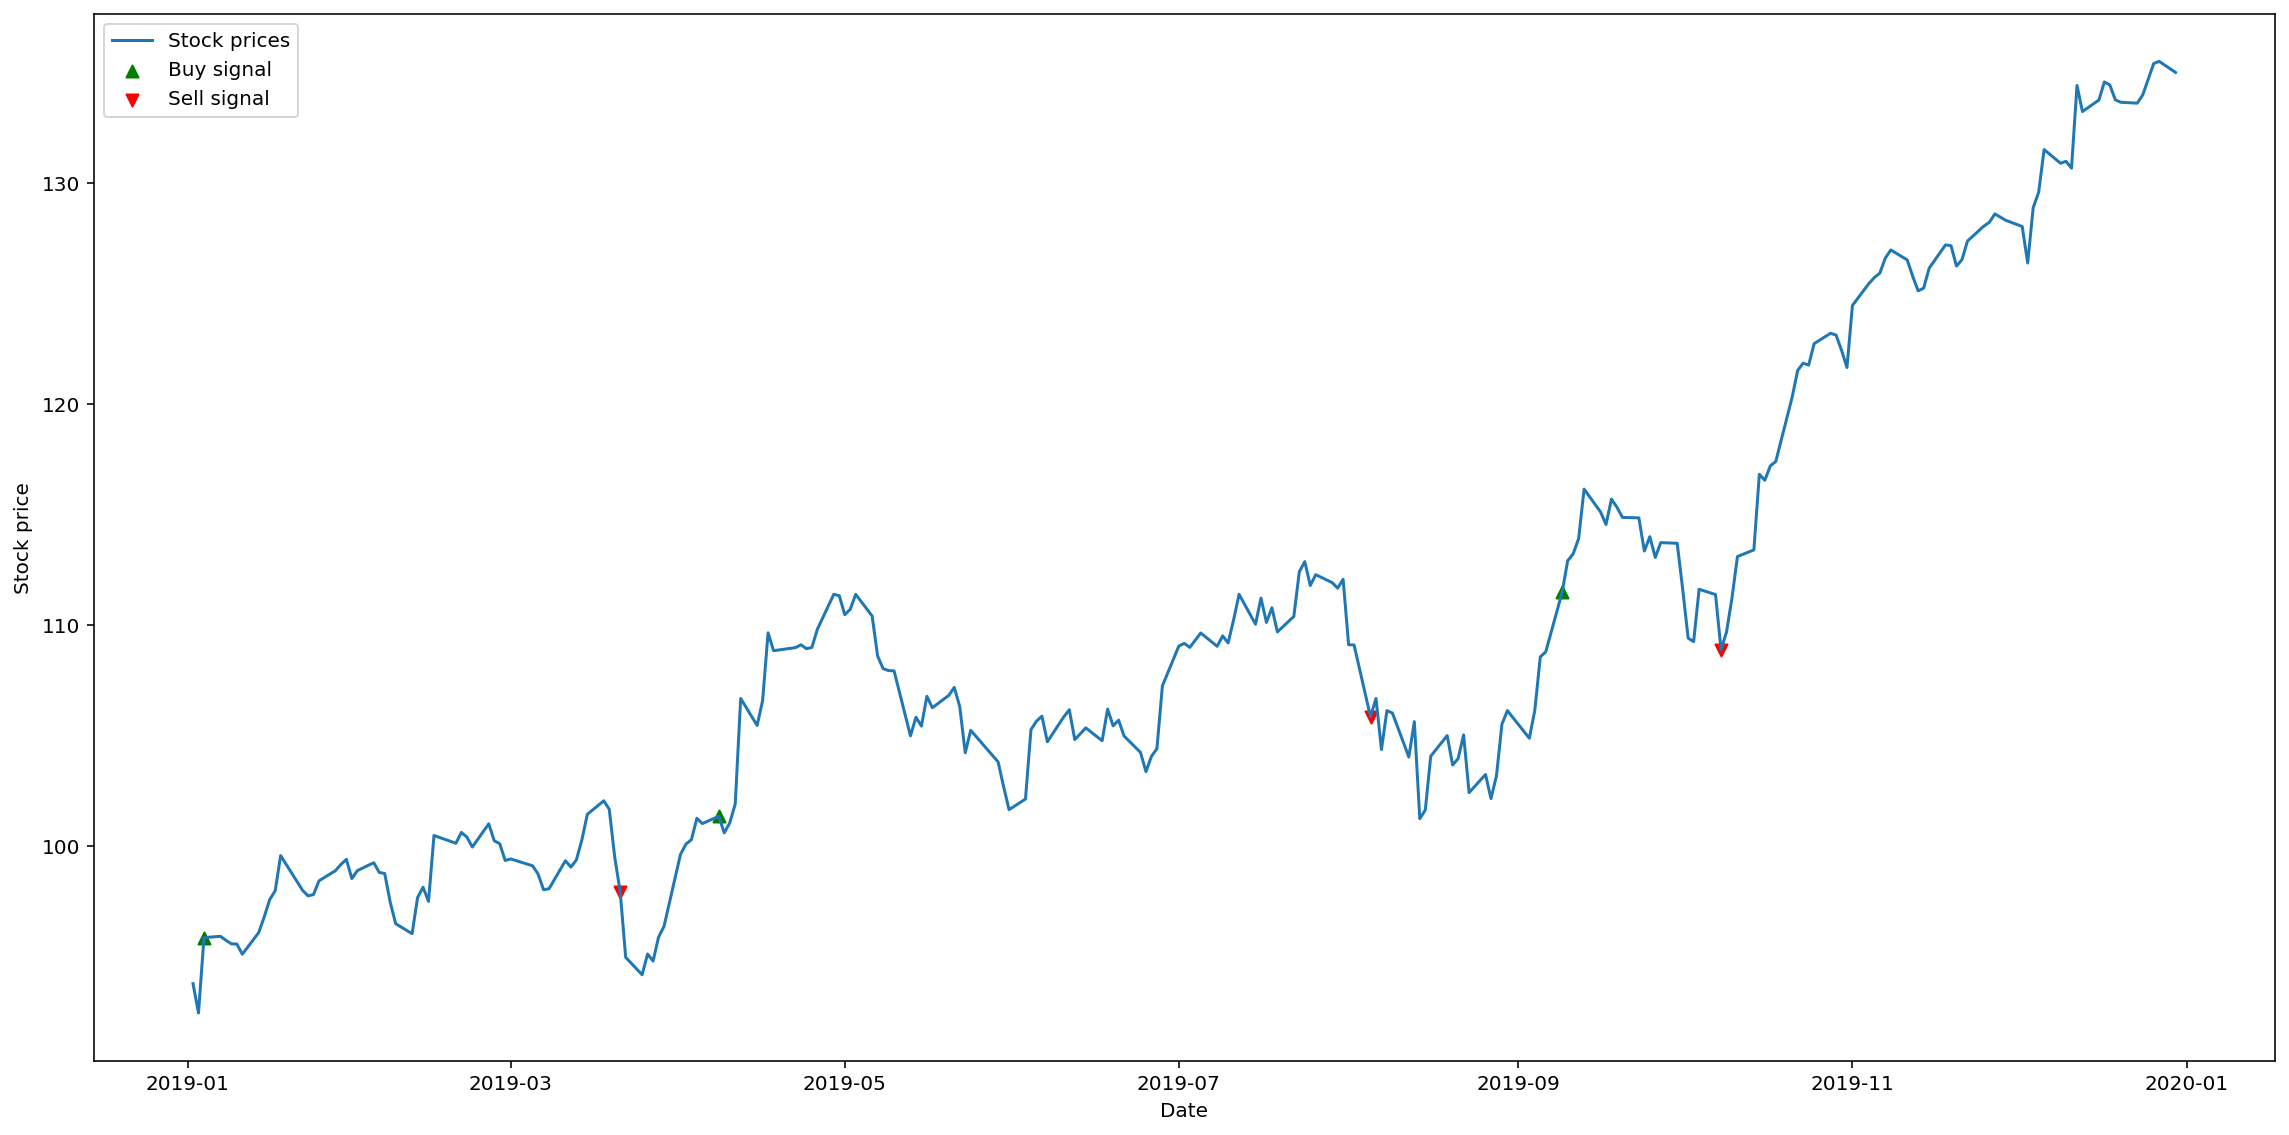

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max   	mean    	std   
0  	1000  	-4.76458	55.992	0.895151	6.5895
1  	647   	-4.77047	53.7259	1.6356  	8.50412
2  	648   	-8.56442	55.2329	3.31081 	11.8643
3  	669   	-5.51188	55.2329	6.90838 	16.2892
4  	659   	-7.8378 	59.9175	11.7671 	19.9292
5  	645   	-6.2048 	59.9175	20.856  	23.0148
6  	642   	-4.80055	59.9175	28.4713 	23.3931
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Best average net profit: 13.9342891630248
CPU times: user 6min 45s, sys: 409 ms, total: 6min 45s
Wall time: 6min 46s


In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[123, 66], [9, 62, 28], [4, 1]]
Net profit of strategy: 33.924825
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 34.316028%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 1
Number of sell signals: 1


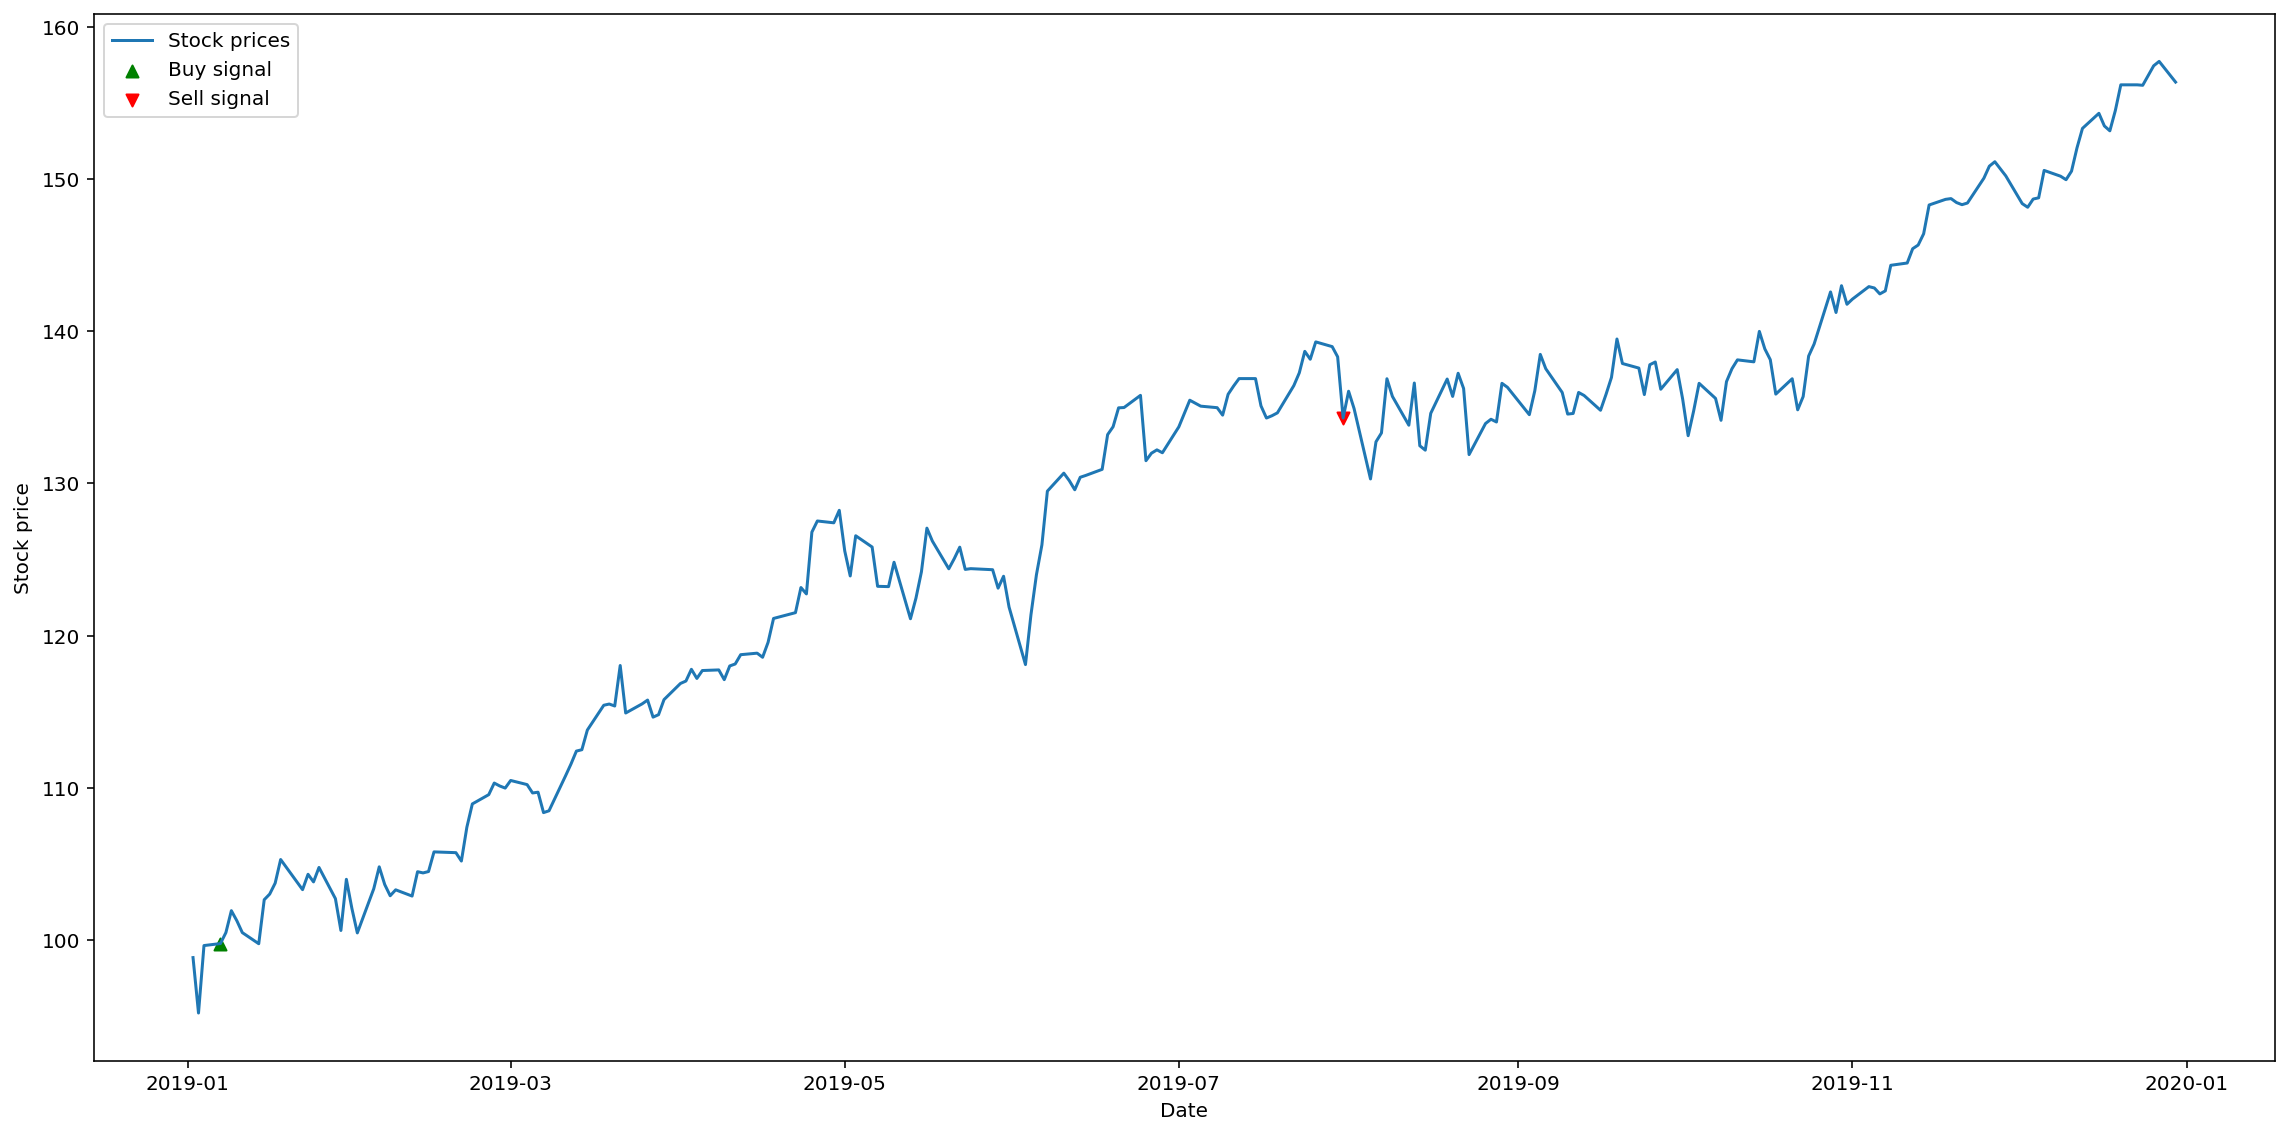

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean      	std   
0  	1000  	-13.9924	23.3106	-0.0524321	2.1362
1  	647   	-8.16488	22.2549	0.329252  	2.41967
2  	648   	-8.1662 	22.2549	0.553018  	3.04078
3  	669   	-18.691 	26.1226	1.13677   	4.21422
4  	659   	-11.2954	26.1226	2.20891   	5.52591
5  	645   	-11.3415	28.5316	3.95386   	6.92862
6  	642   	-27.3615	28.5316	6.3016    	8.21148
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Best average net profit: 4.641533539667738
CPU times: user 6min 19s, sys: 391 ms, total: 6min 20s
Wall time: 6min 20s


In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[85, 47], [8, 48, 22], [8, 1]]
Net profit of strategy: 14.685325
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 20.188789%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 3
Number of sell signals: 3


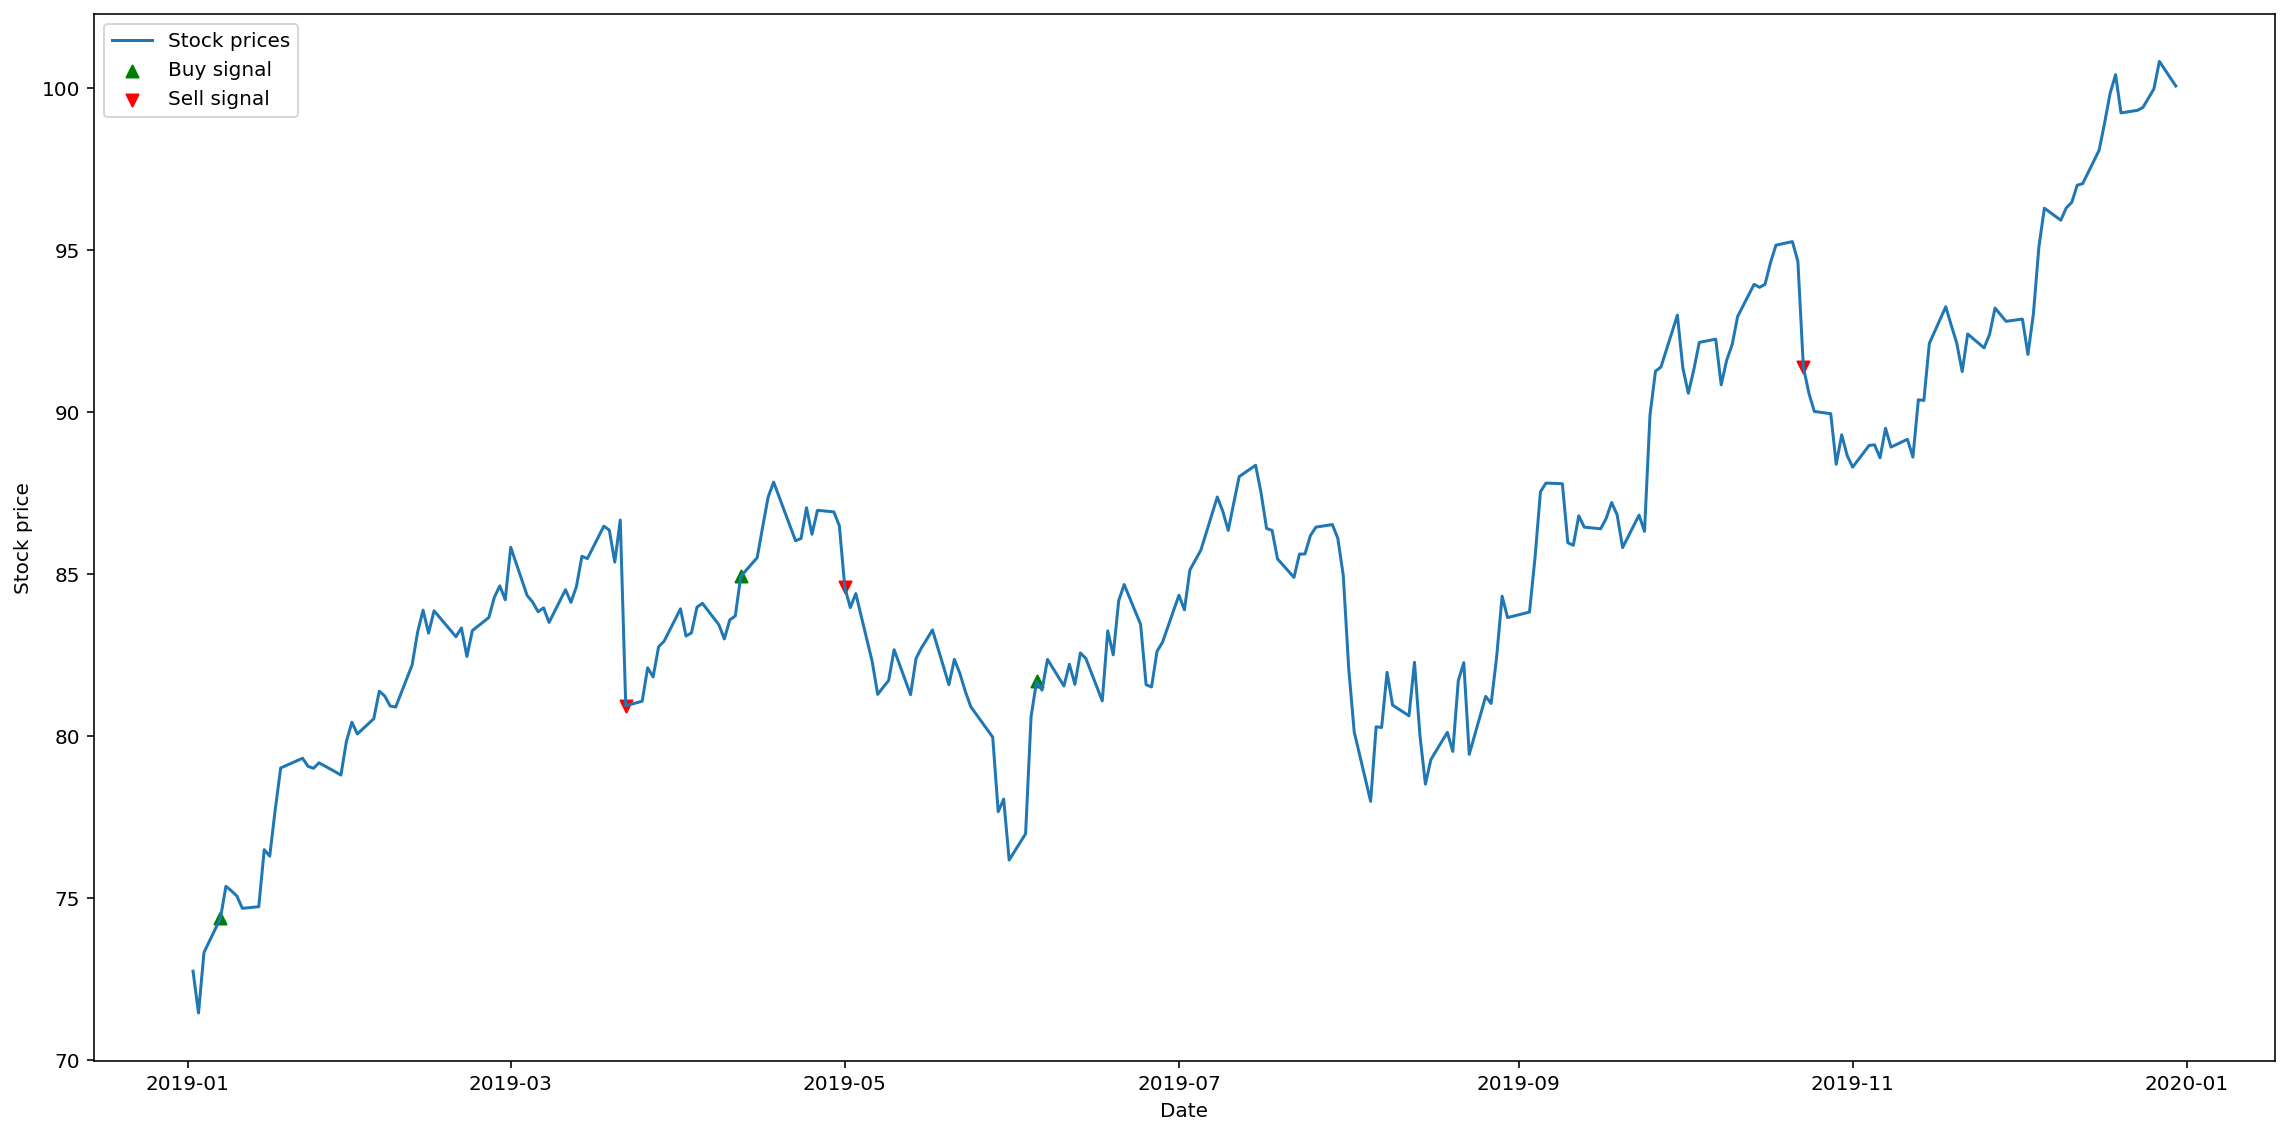

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=6)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-3.77118	145.483	2.17108	14.6639
1  	647   	0       	148.346	5.67659	24.366 
2  	648   	0       	148.346	11.3106	32.8308
3  	669   	0       	148.908	24.7961	46.5398
4  	659   	-4.3728 	151.482	44.143 	55.7537
5  	645   	-6.4515 	154.502	69.7301	59.3876
6  	642   	-27.3482	154.502	90.6377	57.2043
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Best average net profit: 21.352862265231007
CPU times: user 7min 4s, sys: 437 ms, total: 7min 4s
Wall time: 7min 4s


In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[31, 7, 46], [28, 1]]
Net profit of strategy: -13.029925
Net profit of buy and hold: 52.403650
Percentage profit of strategy: -5.511579%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 3
Number of sell signals: 3


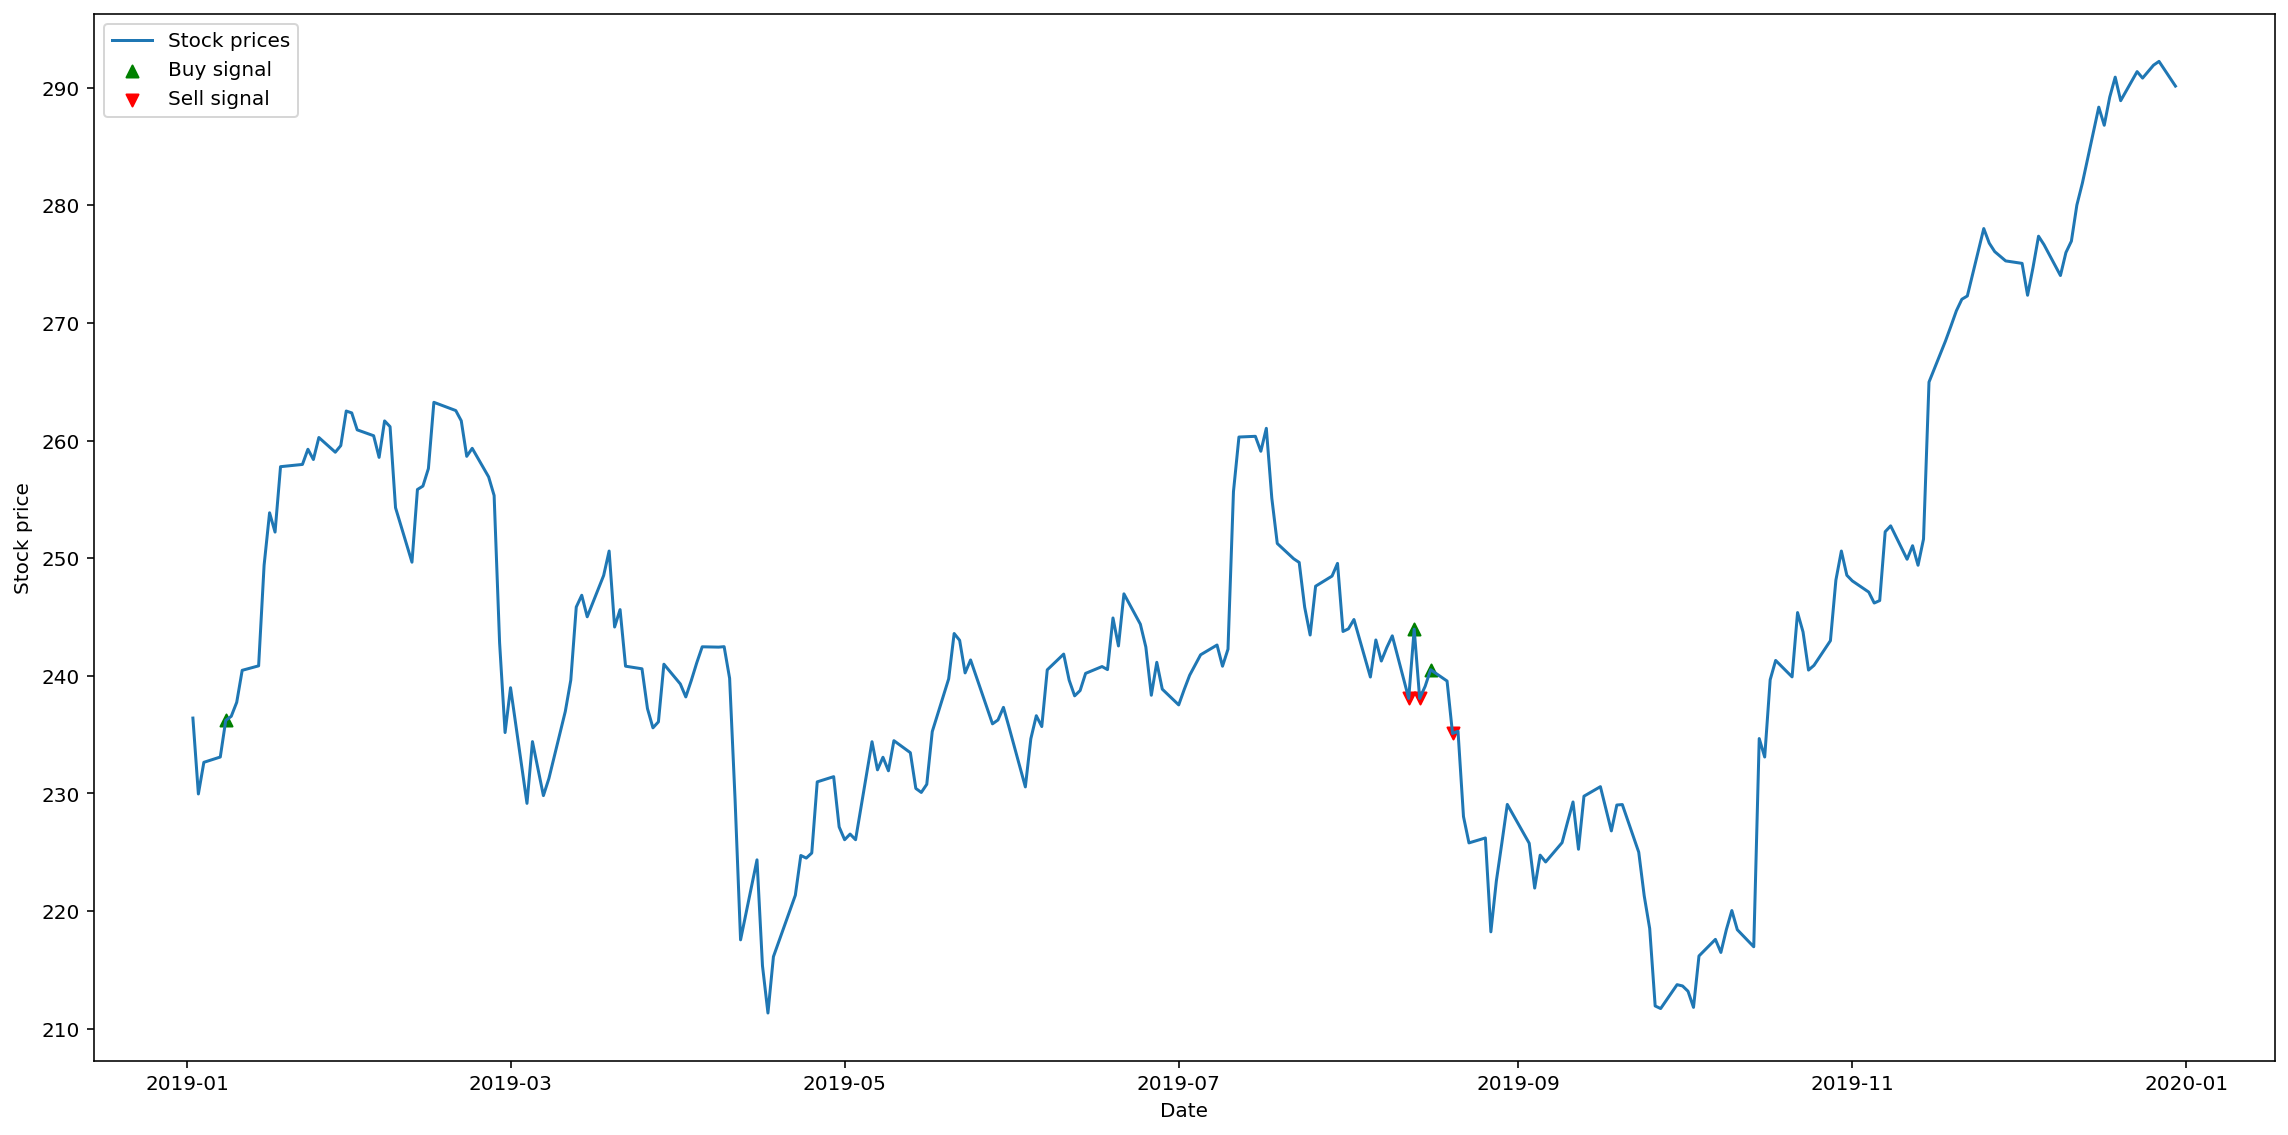

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[19.72468736287847, 24.010750329091714]","[34.65026073791617, 58.64860659414599]","[0.0, 29.842999999999996]","[0.0, 15.491510365251738]","[0.0, -2.060810810810815]","[3.899961300309549, 2.4338235294117707]","[0.0, 39.54596977329974]","[0.0, 10.796113655545895]","[5.446625766871172, 13.403803680981593]","[-12.25523931855058, -17.72292455381287]","[2.576420727156442, 43.339375199914684]","[34.31602771596196, 57.507561197653246]","[20.188788836953464, 36.95081798185318]","[-5.511579459413749, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

7.359710976434492

In [52]:
np.mean(bh_results)

23.882430279472867